# CIFAR-10 Dataset

The dataset used in this notebook is downloaded from [here](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR-10 dataset is a subset of 80 million tiny image dataset. CIFAR-10 consists of 60,000 images in total. Training data has around 50k images and the test data has 10k images. CIFAR-10 dataset has 10 categories with 6000 images in each category.

### Importing packages

In this notebook, we will be mainly working with PyTorch for building and training ConvNets on CIFAR10 Dataset. Using PyTorch makes things more easier to understand however, whatever we do here must be similar in TensorFlow as well. 

*Note : The python scripts for this notebook will be slightly different from this notebook. But all the concepts used will be the same.*

In [1]:
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.transforms import ToTensor,Compose,RandomHorizontalFlip, Normalize, ToPILImage, RandomRotation, ColorJitter
from torchvision.utils import make_grid

### Extract the downloaded dataset

The dataset downloaded has 6 batches, `data_batch1, data_batch2,..., data_batch5` are the training batches. Each batch has 10k images in it. `test_batch` is the batch that is meant to be used for model testing. The test batch contains 10k images.

The batches has been created using cPickle. Each batch is an array of shape (10000,3072) where 10,000 is number of images and 3072 is the pixel values of the image.

Extracting the dataset according to the method suggested in the [CIFAR-10 Website](https://www.cs.toronto.edu/~kriz/cifar.html).

In [2]:
def extract(filename):
    with open(filename,"rb") as f:
        batch_data = pickle.load(f,encoding="bytes")
    return batch_data

In [3]:
data = [] #Store all batches in a list
for files in os.listdir("./cifar-10-batches-py/"):
    if "_batch" in files:
        data.append(extract(os.path.join('cifar-10-batches-py',files)))

### Creating a Custom Dataset Class using `Dataset` Module

Using the above method to extarct, we will now create a custom dataset class which inherits the `Dataset` class from `torch.utils.data` package. Creating this custom dataset class is essential as it will help us easily manage our dataset and apply the data augmentation during runtime. The `DataLoader` class takes full advantage of this custom dataset class. Instead of loading all the images at once, the `DataLoader` class reads batches of data. Even though we already have batches of data in our dataset, creating this custom class allows us to use any batch_size. Currently, the batches_data have 10k images in them. Having so many images in one batch may not fit in memory. Hence to change this batch_size, we will create a custom dataset class.

In [4]:
class CIFAR10(Dataset):
    
    def __init__(self,root,train=True,transforms=None):
        self.root = root
        self.transforms = transforms
        self.split = train
        
        self.data = []
        self.targets = []
        self.train_data = [file for file in os.listdir(root) if "data_batch" in file]
        self.test_data = [file for file in os.listdir(root) if "test_batch" in file]
                
        data_split = self.train_data if self.split else self.test_data
        
        for files in data_split:
            entry = self.extract(os.path.join(root,files))
            self.data.append(entry["data"])
            self.targets.extend(entry["labels"])
                
        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))
        self.load_meta()
        
    def extract(self,filename):
        with open(filename,"rb") as f:
            batch_data = pickle.load(f,encoding="latin1")
        return batch_data  
    
    def load_meta(self):
        path = os.path.join(self.root,"batches.meta")
        with open(path,"rb") as infile:
            data = pickle.load(infile,encoding="latin1")
            self.classes = data["label_names"]
            self.classes_to_idx = {_class:i for i,_class in enumerate(self.classes)}
            
    def plot(self,image,target=None):
        if target is not None:
            print(f"Target :{target} class :{self.classes[target]}")
        plt.figure(figsize=(2,2))
        plt.imshow(image.permute(1,2,0))
        plt.show()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,idx):
        image,target = self.data[idx],self.targets[idx]
        image = Image.fromarray(image)
        
        if self.transforms:
            image = self.transforms(image)
            
        return image,target

In [5]:
train_set = CIFAR10(root="./cifar-10-batches-py",train=True,
                    transforms=Compose([
                        ToTensor()]))
test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                    transforms=Compose([
                        ToTensor()]))

Target :8 class :ship


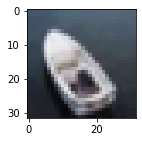

In [6]:
batch = train_set[1036]
img,label = batch
train_set.plot(img,label)

### Building ConvNet Model

Now that we are done with constructing the dataset class, it's time to build a ConvNet model. We will also create a class which specifies the training configurations so that it becomes easier for cross-validation.

In [7]:
class ConvNet(nn.Module):
    
    def __init__(self):
        super(ConvNet,self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=8,stride=1,kernel_size=(3,3),padding=1)
        self.conv2 = nn.Conv2d(in_channels=8,out_channels=32,kernel_size=(3,3),padding=1,stride=1)
        self.conv3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=(3,3),padding=1,stride=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=(3,3),padding=1,stride=1)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=(3,3),stride=1)

        self.fc1 = nn.Linear(in_features=6*6*256,out_features=256)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=64)
        self.fc4 = nn.Linear(in_features=64,out_features=10)
        
        self.max_pool = nn.MaxPool2d(kernel_size=(2,2),stride=2)
        self.dropout = nn.Dropout2d(p=0.5)
        
    def forward(self,x,targets):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.max_pool(x)
        x = self.conv5(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = x.view(-1,6*6*256)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        logits = self.fc4(x)
        
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits,targets)
        return logits,loss
    
    def configure_optimizers(self,config):
        optimizer = optim.Adam(self.parameters(),lr=config.lr,betas=config.betas,weight_decay=config.weight_decay)
        return optimizer

In [8]:
model = ConvNet()
print(model)

ConvNet(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
  (max_pool): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


### Creating a Training Configuration Class

I often see people just specify the training configurations directly. I don't prefer this way. We will create a simple training config class and pass that config class when we train our model. This makes it a neat way of training.


In [9]:
class TrainingConfig:
    
    lr=3e-4
    betas=(0.9,0.995)
    weight_decay=5e-4
    num_workers=0
    max_epochs=10
    batch_size=64
    ckpt_path=None #Specify a model path here. Ex: "./Model.pt"
    shuffle=True
    pin_memory=True
    verbose=True
    
    def __init__(self,**kwargs):
        for key,value in kwargs.items():
            setattr(self,key,value)

In [10]:
train_config = TrainingConfig()

### Building the Training Loop

Now, we will be creating a simple training loop to train our model. It may look complicated but trust me, when you understand what is going on, it's simple. It also shows how other libraries like TensorFlow will hide some important stuff from you.

In [11]:
class Trainer:
    def __init__(self,model,train_dataset,test_dataset,config):
        self.model = model
        self.train_dataset=train_dataset
        self.test_dataset=test_dataset
        self.config = config
        
        self.train_losses = []
        self.train_accuracies = []
        self.test_losses = []
        self.test_accuracies = []
        
        self.device = "cpu"
        if torch.cuda.is_available():
            self.device = torch.cuda.current_device()
            self.model = self.model.to(self.device)
    
    def save_checkpoint(self):
        raw_model = self.model.module if hasattr(self.model,"module") else self.model
        torch.save(raw_model.state_dict(),self.config.ckpt_path)
        print("Model Saved!")
        
    def train(self):
        model,config = self.model,self.config
        raw_model = self.model.module if hasattr(self.model,"module") else self.model
        optimizer = raw_model.configure_optimizers(config)
        
        def run_epoch(split):
            is_train = split=="train"
            if is_train:
                model.train()
            else:
                model.eval() #important don't miss this. Since we have used dropout, this is required.
            data = self.train_dataset if is_train else self.test_dataset
            loader = DataLoader(data,batch_size=config.batch_size,
                                shuffle=config.shuffle,
                                pin_memory=config.pin_memory,
                                num_workers=config.num_workers)
            
            losses = []
            accuracies = []
            correct = 0
            num_samples = 0
            
            pbar = tqdm(enumerate(loader),total=len(loader)) if is_train and config.verbose else enumerate(loader)
            for it,(images,targets) in pbar:
                images = images.to(self.device)
                targets = targets.to(self.device)
                num_samples += targets.size(0)
                
                with torch.set_grad_enabled(is_train):
                    #forward the model
                    logits,loss = model(images,targets)
                    loss = loss.mean()
                    losses.append(loss.item())
                    
                with torch.no_grad():
                    predictions = torch.argmax(logits,dim=1) #softmax gives prob distribution. Find the index of max prob
                    correct+= predictions.eq(targets).sum().item()
                    accuracies.append(correct/num_samples)
                    
                if is_train:
                    model.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    if config.verbose:
                        pbar.set_description(f"Epoch:{epoch+1} iteration:{it+1} | loss:{np.mean(losses)} accuracy:{np.mean(accuracies)} lr:{config.lr}")
                    
                    self.train_losses.append(np.mean(losses))
                    self.train_accuracies.append(np.mean(accuracies))
            
            if not is_train:
                test_loss = np.mean(losses)
                if config.verbose:
                    print(f"\nEpoch:{epoch+1} | Test Loss:{test_loss} Test Accuracy:{correct/num_samples}\n")
                self.test_losses.append(test_loss)
                self.test_accuracies.append(correct/num_samples)
                return test_loss
                
        best_loss = float('inf')
        test_loss = float('inf')
        
        for epoch in range(config.max_epochs):
            run_epoch('train')
            if self.test_dataset is not None:
                test_loss = run_epoch("test")
                
            good_model = self.test_dataset is not None and test_loss < best_loss
            if config.ckpt_path is not None and good_model:
                best_loss = test_loss
                self.save_checkpoint()

### Dumb Baselines

In this section we will get a dumb baseline score which we can use to compare our model against. To get dumb baseline scores, we will pass a zero input image and ask our model to predict something. By doing this, we can see whether our model has learnt to extract any information from the images at all when we pass an actual image from dataset.

In [12]:
zero_images = torch.zeros([10,3,32,32])
labels = torch.tensor(data[0][b"labels"][:10])

net = ConvNet()
optimizer = optim.Adam(net.parameters(),lr=3e-4)

losses = []
for epoch in range(1000):
    logits,loss = net(zero_images,labels)
    losses.append(loss.item())
    net.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Loss :",np.mean(losses))

Loss : 2.0386426706314085


Looks like we cannot achieve a loss lower than 2.03. We better beat this when we provide our model with actual data from the dataset. If we cannot beat this then, it suggests that our model is not learning to extarct any information from the images we show it.

### Overfit Test

Our training loop is ready! We now have to check if our model is wired properly and that it can overfit a single batch of training data. Doing this will save us a lot of time. Overfitting a small batch of data will tell us that the model is capable of learning and that there is no bug in our model. If the overfit test is not done, and we start training our model with the full dataset directly, we will not be able to find a bug and we will waste time in training a network that will not learn anything.

In [13]:
train_set = CIFAR10(root="./cifar-10-batches-py",train=True,transforms=ToTensor())

small_batch,train_data = random_split(train_set,[10,len(train_set)-10]) #take 10 examples from the trainset

trainconfig = TrainingConfig(max_epochs=200,batch_size=10,weight_decay=0,num_workers=0)
trainer = Trainer(model,train_dataset=small_batch,test_dataset=None,config=trainconfig)

trainer.train()

Epoch: 1 iteration: 1 | loss:2.2846438884735107 accuracy: 0.1 lr: 0.0003: 100%|██████████| 1/1 [00:01<00:00,  1.49s/it]
Epoch: 2 iteration: 1 | loss:2.2822694778442383 accuracy: 0.1 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.64it/s]
Epoch: 3 iteration: 1 | loss:2.278874158859253 accuracy: 0.1 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 199.99it/s]
Epoch: 4 iteration: 1 | loss:2.274754285812378 accuracy: 0.1 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
Epoch: 5 iteration: 1 | loss:2.268786668777466 accuracy: 0.1 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Epoch: 6 iteration: 1 | loss:2.2620298862457275 accuracy: 0.2 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]
Epoch: 7 iteration: 1 | loss:2.2556614875793457 accuracy: 0.2 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.61it/s]
Epoch: 8 iteration: 1 | loss:2.248899459838867 accuracy: 0.2 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 199.94it/s]
Epoch: 9 iteration: 1 | loss:2.223925

Epoch: 134 iteration: 1 | loss:0.03783215954899788 accuracy: 1.0 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Epoch: 135 iteration: 1 | loss:0.04665109142661095 accuracy: 1.0 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.62it/s]
Epoch: 136 iteration: 1 | loss:0.0681254044175148 accuracy: 1.0 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Epoch: 137 iteration: 1 | loss:0.24744188785552979 accuracy: 0.9 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 166.63it/s]
Epoch: 138 iteration: 1 | loss:0.04304865747690201 accuracy: 1.0 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 200.00it/s]
Epoch: 139 iteration: 1 | loss:0.04784528166055679 accuracy: 1.0 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 199.96it/s]
Epoch: 140 iteration: 1 | loss:0.16925184428691864 accuracy: 0.9 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]
Epoch: 141 iteration: 1 | loss:0.07209201157093048 accuracy: 1.0 lr: 0.0003: 100%|██████████| 1/1 [00:00<00:00, 199.97it/s]
Epoch: 14

Looks like we are able to overfit successfully. This indicates that there are no bugs in our model architecture. This step is very important as it will save a lot of time in future. Can't overfit? Then we need to take a look at our model architecture to resolve some bugs or create a new one altogether.

### Visualizing Batch Images

Another important thing to observe is the dataset itself. Visualizing what goes into your model is very essential. It is at this stage that you will find certain pre-processing errors that may have happened but you didn't know that it had occured. Uunfortunately, our model doesn't know which data is bad and which data is good. It takes in everything. However, model may figure out certain pre-processing errors and will just ignore that example. But this will not happen all the time.  

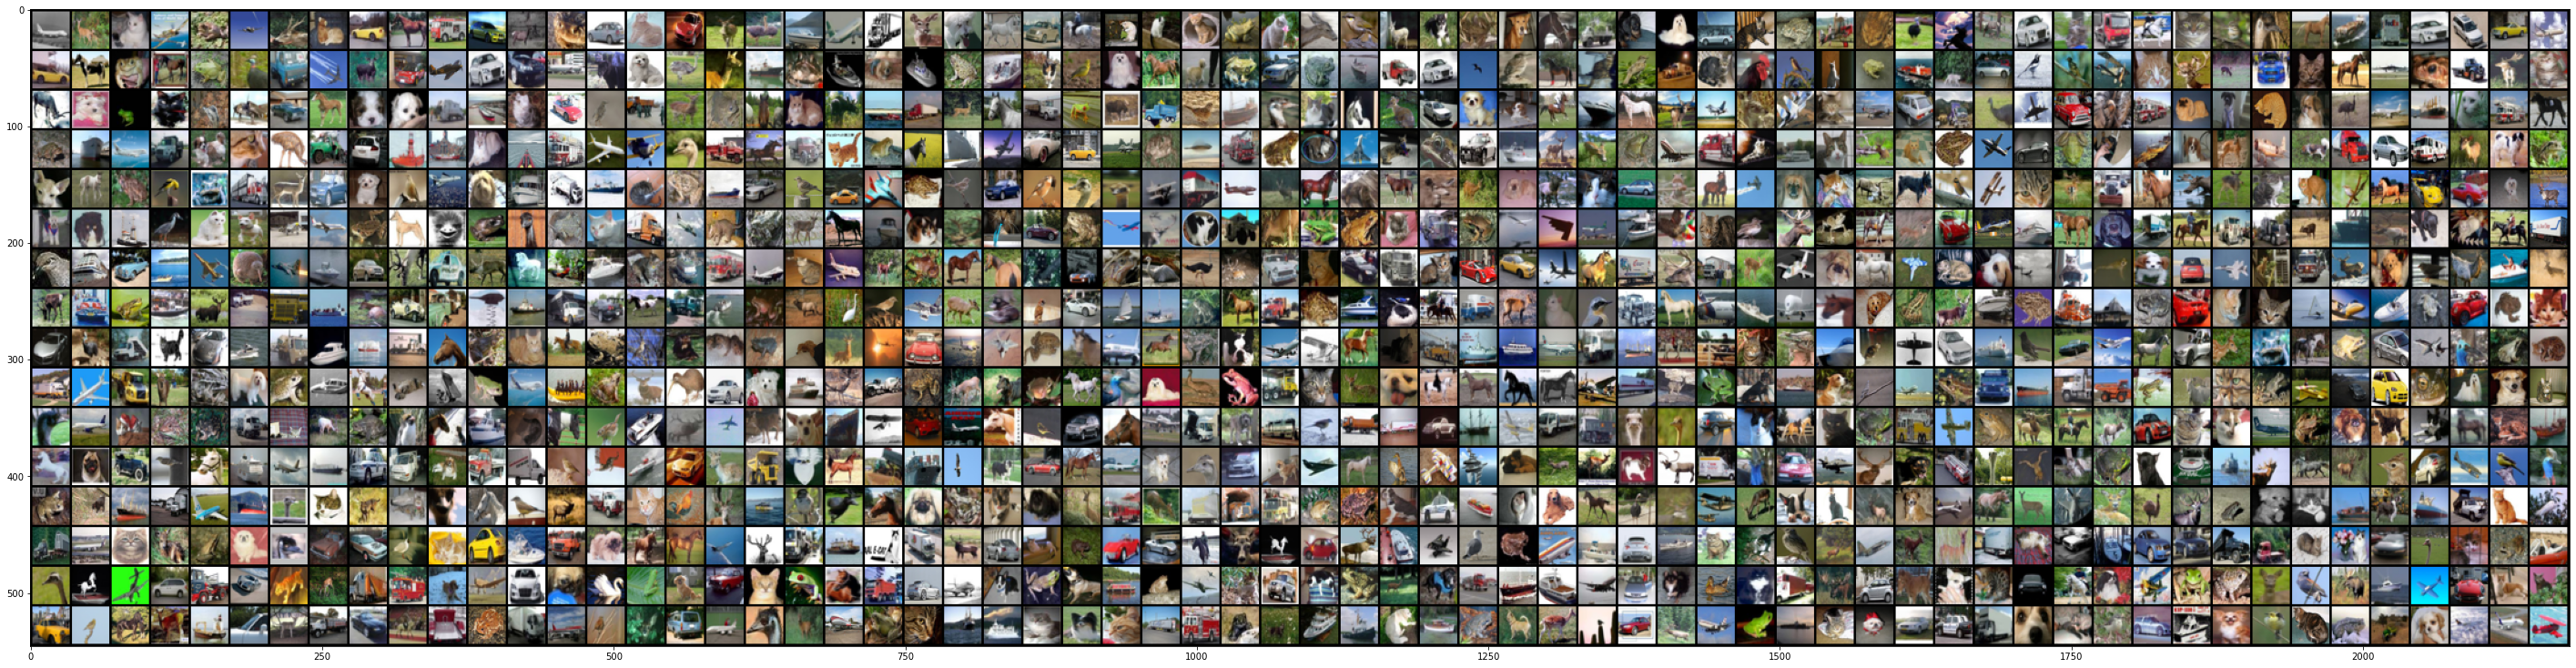

In [14]:
train_loader = DataLoader(train_set,batch_size=1024,shuffle=True)
batch = iter(train_loader)
images,labels = next(batch)
grid = make_grid(images,nrow=64)
plt.figure(figsize=(50,50))
plt.imshow(grid.permute(1,2,0))
plt.show()
# plt.savefig("CIFAR10")

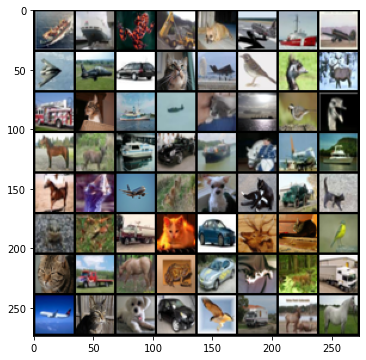

In [15]:
train_loader = DataLoader(train_set,batch_size=64,shuffle=True)
batch = iter(train_loader)
images,labels = next(batch)
grid = make_grid(images,nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.show()

The above image is a subset of training images of `batch_size=64`. Since we are not using any exotic data augmentations like RandomHorizontalFlips, ColorJittering and stuff as of now, we need not worry too much about having pre-processing errors in our dataset. However, pre-processing errors are very common in real world applications.

### Training ConvNet on CIFAR-10

We can now train our model on the dataset we have downloaded. Hopefully things go well :) 

Final Model Stats achieved after training has completed.

Training Time : min

Training Device : RTX 3080 GPU

Epochs Trained For : 300

Train Loss Achieved : 

Train Accuracy Achieved : 

Test Loss Achieved : 

Test Accuracy Achieved : 

Learning Rate : 

Weight Decay : 

Batch Size : 64

### Hyperparameter Optimization

There are many methods of doing hyperparameter optimization. You may be familiar with GridSearchCV that is offen used in machine learning. Here we will not be using GridSearchCV to find the right values for our hyper parameters. Instead we will use the coarse to fine strategy to find descent values for them. 

In [12]:
import random

torch.manual_seed(0)
random.seed(0)

In [17]:
Model = ConvNet()
train_set = CIFAR10(root="./cifar-10-batches-py",train=True,
                    transforms=Compose([
                        ToTensor(),
                        Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                    ]))

test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                   transforms=Compose([
                        ToTensor(),
                        Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                    ]))

We will use a very low learning rate of 1e-6 first and see how it performs.

In [18]:
train_config = TrainingConfig(max_epochs=7,lr=1e-6,batch_size=64,weight_decay=0,num_workers=0,verbose=True)
trainer = Trainer(model=Model,train_dataset=train_set,test_dataset=test_set,config=train_config)
trainer.train()

Epoch: 1 iteration: 782 | loss:2.304411681106938 accuracy: 0.10264411882560155 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 81.70it/s] 
Epoch: 2 iteration: 13 | loss:2.300433580691998 accuracy: 0.08496408105783107 lr: 1e-06:   1%|          | 9/782 [00:00<00:09, 79.63it/s] 


Epoch 1 | Test Loss: 2.3038014439260883 Test Accuracy: 0.1



Epoch: 2 iteration: 782 | loss:2.303141687837098 accuracy: 0.09919359443393817 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 81.47it/s] 
Epoch: 3 iteration: 14 | loss:2.3009870733533586 accuracy: 0.11983844218777255 lr: 1e-06:   1%|          | 8/782 [00:00<00:09, 79.19it/s]


Epoch 2 | Test Loss: 2.302064505352336 Test Accuracy: 0.1



Epoch: 3 iteration: 782 | loss:2.300329840701559 accuracy: 0.10089214669225395 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 81.14it/s] 
Epoch: 4 iteration: 13 | loss:2.29929309624892 accuracy: 0.09693096366774252 lr: 1e-06:   1%|          | 8/782 [00:00<00:09, 78.41it/s]  


Epoch 3 | Test Loss: 2.2977217883820744 Test Accuracy: 0.1



Epoch: 4 iteration: 782 | loss:2.2948004104902067 accuracy: 0.10222318068941447 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 80.68it/s]
Epoch: 5 iteration: 14 | loss:2.2903349910463606 accuracy: 0.11395368953962705 lr: 1e-06:   1%|          | 8/782 [00:00<00:09, 77.65it/s]


Epoch 4 | Test Loss: 2.289100226323316 Test Accuracy: 0.1115



Epoch: 5 iteration: 782 | loss:2.283634016885782 accuracy: 0.10735581725510239 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 80.45it/s] 
Epoch: 6 iteration: 14 | loss:2.2721043654850552 accuracy: 0.12140590064697207 lr: 1e-06:   1%|          | 8/782 [00:00<00:09, 78.41it/s]


Epoch 5 | Test Loss: 2.272851301606294 Test Accuracy: 0.1283



Epoch: 6 iteration: 782 | loss:2.2634960894694416 accuracy: 0.13643879805698764 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 79.15it/s]
Epoch: 7 iteration: 14 | loss:2.2446923766817366 accuracy: 0.15945293855450107 lr: 1e-06:   1%|          | 8/782 [00:00<00:09, 77.65it/s]


Epoch 6 | Test Loss: 2.244782224582259 Test Accuracy: 0.1988



Epoch: 7 iteration: 782 | loss:2.2324376072725065 accuracy: 0.17789093111497295 lr: 1e-06: 100%|██████████| 782/782 [00:09<00:00, 80.34it/s]



Epoch 7 | Test Loss: 2.20466952111311 Test Accuracy: 0.2114



With a learning rate of 1e-6, the train_loss is barely moving. Suggests that learning rate is too low.

We will try a learning rate of 1e-3 and check the results.

In [20]:
Model = ConvNet() #reinit the model parameters
train_config = TrainingConfig(max_epochs=10,lr=1e-3,batch_size=64,weight_decay=0,num_workers=0,verbose=True)
trainer = Trainer(model=Model,train_dataset=train_set,test_dataset=test_set,config=train_config)
trainer.train()

Epoch: 1 iteration: 782 | loss:1.7649976992241256 accuracy: 0.25318426586890813 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 79.89it/s]
Epoch: 2 iteration: 13 | loss:1.44841468334198 accuracy: 0.49031272546897536 lr: 0.001:   1%|          | 8/782 [00:00<00:10, 72.71it/s] 


Epoch 1 | Test Loss: 1.3923171295481882 Test Accuracy: 0.493



Epoch: 2 iteration: 782 | loss:1.3639650305976039 accuracy: 0.4845885153923614 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 78.53it/s] 
Epoch: 3 iteration: 14 | loss:1.2476724641663688 accuracy: 0.5525571681542665 lr: 0.001:   1%|          | 8/782 [00:00<00:10, 76.17it/s]


Epoch 2 | Test Loss: 1.1750858794352053 Test Accuracy: 0.5868



Epoch: 3 iteration: 782 | loss:1.1841854223662325 accuracy: 0.5640170281742842 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 79.36it/s]
Epoch: 4 iteration: 13 | loss:1.0439176788696876 accuracy: 0.6233438269796443 lr: 0.001:   1%|          | 7/782 [00:00<00:11, 69.98it/s]


Epoch 3 | Test Loss: 1.0320957504260313 Test Accuracy: 0.6361



Epoch: 4 iteration: 782 | loss:1.0853747036450965 accuracy: 0.6094508166976349 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 79.49it/s]
Epoch: 5 iteration: 14 | loss:1.0328695263181413 accuracy: 0.6462300936910311 lr: 0.001:   1%|          | 8/782 [00:00<00:09, 79.98it/s]


Epoch 4 | Test Loss: 1.0024737203197114 Test Accuracy: 0.6494



Epoch: 5 iteration: 782 | loss:1.005917905922741 accuracy: 0.6360933991341733 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 80.26it/s] 
Epoch: 6 iteration: 14 | loss:0.8990315496921539 accuracy: 0.7114930363535275 lr: 0.001:   1%|          | 9/782 [00:00<00:09, 81.06it/s]


Epoch 5 | Test Loss: 0.9049365953275352 Test Accuracy: 0.6829



Epoch: 6 iteration: 782 | loss:0.9490300961924941 accuracy: 0.6673490158391558 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 80.84it/s]
Epoch: 7 iteration: 14 | loss:0.9199238887854985 accuracy: 0.6690088805044162 lr: 0.001:   1%|          | 9/782 [00:00<00:09, 81.06it/s]


Epoch 6 | Test Loss: 0.8634070355421418 Test Accuracy: 0.6979



Epoch: 7 iteration: 782 | loss:0.8911179512205636 accuracy: 0.6831088558743607 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 80.29it/s]
Epoch: 8 iteration: 13 | loss:0.8868800951884344 accuracy: 0.691088038564 lr: 0.001:   1%|          | 8/782 [00:00<00:09, 79.98it/s]    


Epoch 7 | Test Loss: 0.8158349282802291 Test Accuracy: 0.712



Epoch: 8 iteration: 782 | loss:0.8450164224790491 accuracy: 0.701444866050886 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 80.86it/s] 
Epoch: 9 iteration: 14 | loss:0.7814603533063617 accuracy: 0.7021436029248529 lr: 0.001:   1%|          | 9/782 [00:00<00:09, 81.06it/s]


Epoch 8 | Test Loss: 0.8056558418046137 Test Accuracy: 0.7216



Epoch: 9 iteration: 782 | loss:0.8001511081710191 accuracy: 0.7205014240906873 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 80.48it/s]
Epoch: 10 iteration: 15 | loss:0.7909963250160217 accuracy: 0.7361302730833983 lr: 0.001:   1%|          | 9/782 [00:00<00:09, 80.34it/s]


Epoch 9 | Test Loss: 0.7671225450600788 Test Accuracy: 0.7284



Epoch: 10 iteration: 782 | loss:0.761782485124705 accuracy: 0.7306113458798947 lr: 0.001: 100%|██████████| 782/782 [00:09<00:00, 80.10it/s] 



Epoch 10 | Test Loss: 0.7546340857341791 Test Accuracy: 0.737



We can see that the loss of both train_set and the test_set is going down. Which is a good sign. Hence we will search for values closer to 1e-3 in log space so that we can get better values for our hyperparameters.

*Note : In the above training process we searched for a good learning rate first. Learning rate affects your model the most. Other parameters come next.*

In [14]:
for runs in range(20):
    lr = 10**(np.random.uniform(-4,-3))
    weight_decay = 10**(np.random.uniform(-4,-5))
    
    Model = ConvNet()
    Model.load_state_dict(torch.load("./ConvNet_Model1.pt"))
    training_config = TrainingConfig(max_epochs=5,lr=lr,weight_decay=weight_decay,batch_size=64,verbose=False)
    trainer = Trainer(model=Model,train_dataset=train_set,test_dataset=test_set,config=training_config)
    trainer.train_losses = torch.load("./train_losses.pt")
    trainer.train_accuracies = torch.load("./train_accuracies.pt")
    trainer.test_losses = torch.load("./test_losses.pt")
    trainer.test_accuracies = torch.load("./test_accuracies.pt")
    trainer.train()
    val_acc = np.mean(trainer.test_accuracies)
    print(f"val_acc:{val_acc} lr:{lr} reg:{weight_decay} ({runs+1}/{len(range(20))})")

val_acc:0.8259777049180326 lr:0.00023570926966106847 reg:2.6444459146597265e-05 (1/20)
val_acc:0.8258422950819672 lr:0.0006730468555585516 reg:1.575544003654889e-05 (2/20)
val_acc:0.8259504918032786 lr:0.00043785526462385377 reg:2.234018585329019e-05 (3/20)
val_acc:0.8258852459016393 lr:0.0005391114103650325 reg:8.895188828377837e-05 (4/20)
val_acc:0.8259655737704917 lr:0.00028923746180484894 reg:3.223761491887932e-05 (5/20)
val_acc:0.8259098360655737 lr:0.00011603275038982337 reg:5.7173268983984185e-05 (6/20)
val_acc:0.825915081967213 lr:0.00012147216800643867 reg:2.4618402191697763e-05 (7/20)
val_acc:0.8259078688524588 lr:0.00010661823777719638 reg:2.198199511822751e-05 (8/20)
val_acc:0.8259570491803276 lr:0.00023418757630825395 reg:2.404405330399285e-05 (9/20)
val_acc:0.8259298360655737 lr:0.00021177518183638846 reg:5.857986618433991e-05 (10/20)
val_acc:0.8259298360655737 lr:0.000195354635541606 reg:1.1008355016799067e-05 (11/20)
val_acc:0.8259449180327868 lr:0.00014212134647798946 

Above cell will take some time to get executed. 

Inference from the above hyperparameter optimization process:

We can notice that we are getting good results when the learning rate is between 1e-3 and 1e-4. We will now refine our search space to get much better values.
    

In [24]:
for runs in range(20):
    lr = 10**(np.random.uniform(-3,-4))
    weight_decay = 10**(np.random.uniform(-4,-5))
    
    Model = ConvNet()
    training_config = TrainingConfig(max_epochs=5,lr=lr,weight_decay=weight_decay,batch_size=64,verbose=False)
    trainer = Trainer(model=Model,train_dataset=train_set,test_dataset=test_set,config=training_config)
    trainer.train()
    val_acc = np.mean(trainer.test_accuracies)
    print(f"val_acc:{val_acc} lr:{lr} reg:{weight_decay} ({runs+1}/{len(range(20))})")

val_acc:0.6048 lr:0.0006024583516261666 reg:2.7849034779453823e-05 (1/20)
val_acc:0.5961799999999999 lr:0.0006324597890284011 reg:1.9270886689186566e-05 (2/20)
val_acc:0.5737400000000001 lr:0.0004236762640850999 reg:2.3859643695847502e-05 (3/20)
val_acc:0.5825400000000001 lr:0.0009513963746900665 reg:4.35936465142985e-05 (4/20)
val_acc:0.60484 lr:0.0009572127304052441 reg:9.005955869456908e-05 (5/20)
val_acc:0.48578 lr:0.00013226762566031106 reg:1.1144189685178184e-05 (6/20)
val_acc:0.5908200000000001 lr:0.0005463336204244574 reg:9.249543115828616e-05 (7/20)
val_acc:0.5342 lr:0.0002676867183965373 reg:8.143317406126742e-05 (8/20)
val_acc:0.5388999999999999 lr:0.00028115971944680677 reg:4.554089041640143e-05 (9/20)
val_acc:0.5894199999999999 lr:0.0006098830113737465 reg:2.833985191296804e-05 (10/20)
val_acc:0.5883 lr:0.0006910473754178793 reg:2.4948542174923188e-05 (11/20)
val_acc:0.53336 lr:0.00025549200174104547 reg:3.428873006626896e-05 (12/20)
val_acc:0.5893200000000001 lr:0.0005300

From the above tuning process, we can see that learning rates lower than 0.6e-4 tend to work better. 

In [31]:
for runs in range(20):
#     lr = 10**(np.random.uniform(-4,-3))
    lr = 0.0009446932175584296
    weight_decay = 10**(np.random.uniform(-3,-4))
    
    Model = ConvNet()
    training_config = TrainingConfig(max_epochs=5,lr=lr,weight_decay=weight_decay,batch_size=64,verbose=False)
    trainer = Trainer(model=Model,train_dataset=train_set,test_dataset=test_set,config=training_config)
    trainer.train()
    val_acc = np.mean(trainer.test_accuracies)
    print(f"val_acc:{val_acc} lr:{lr} reg:{weight_decay} ({runs+1}/{len(range(20))})")

val_acc:0.55796 lr:0.0009446932175584296 reg:0.0006705506214945728 (1/20)
val_acc:0.59156 lr:0.0009446932175584296 reg:0.00012097873877082145 (2/20)
val_acc:0.56996 lr:0.0009446932175584296 reg:0.0003087759119145714 (3/20)
val_acc:0.5728200000000001 lr:0.0009446932175584296 reg:0.00045723937238632183 (4/20)
val_acc:0.5963999999999999 lr:0.0009446932175584296 reg:0.0001540521602537679 (5/20)
val_acc:0.60056 lr:0.0009446932175584296 reg:0.00020190156065229812 (6/20)
val_acc:0.59556 lr:0.0009446932175584296 reg:0.00012223484828922148 (7/20)
val_acc:0.59634 lr:0.0009446932175584296 reg:0.0001311905018595714 (8/20)
val_acc:0.6063799999999999 lr:0.0009446932175584296 reg:0.00011257445443209662 (9/20)
val_acc:0.58884 lr:0.0009446932175584296 reg:0.00024825910030057874 (10/20)
val_acc:0.56988 lr:0.0009446932175584296 reg:0.0005972120670876703 (11/20)
val_acc:0.5436799999999999 lr:0.0009446932175584296 reg:0.0009414352248375237 (12/20)
val_acc:0.5756 lr:0.0009446932175584296 reg:0.0004831947643

KeyboardInterrupt: 

*Note : I could not find any other good hyperparameter values other than for the one we got ~60.6% accuracy `(val_acc:0.6063799999999999 lr:0.0009446932175584296 reg:0.00011257445443209662 (9/20))`. So we will we using those values itself for training the model.*

In [12]:
Model = ConvNet()
# model.load_state_dict(torch.load("./ConvNetModel.pt"))
train_set = CIFAR10(root="./cifar-10-batches-py",train=True,
                    transforms=Compose([
                        ToTensor(),
                        RandomHorizontalFlip(),
                        RandomRotation(degrees=10),
                        ColorJitter(brightness=0.5),
                        Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                    ]))

test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                   transforms=Compose([
                        ToTensor(),
                        Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                    ]))

train_config = TrainingConfig(max_epochs=300,
                              lr=0.0009446932175584296,
                              weight_decay=0.00011257445443209662,
                              ckpt_path="./ConvNet_Model1.pt",
                              batch_size=64,
                              num_workers=0)

trainer = Trainer(model,train_dataset=train_set,
                  test_dataset=test_set,config=train_config)

In [13]:
trainer.train()

Epoch:1 iteration:782 | loss:1.8405534562552373 accuracy:0.24485075130532424 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:31<00:00, 24.77it/s]
Epoch:2 iteration:3 | loss:1.6738087733586628 accuracy:0.3828125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:1 | Test Loss:1.5546950382791507 Test Accuracy:0.4103

Model Saved!


Epoch:2 iteration:782 | loss:1.5129550954569941 accuracy:0.42941800962298926 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s]
Epoch:3 iteration:4 | loss:1.3185924291610718 accuracy:0.5188802083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:2 | Test Loss:1.281953126761564 Test Accuracy:0.5269

Model Saved!


Epoch:3 iteration:782 | loss:1.3644878525105888 accuracy:0.4955839348210333 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s] 
Epoch:4 iteration:4 | loss:1.344295084476471 accuracy:0.4970703125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]       


Epoch:3 | Test Loss:1.1747482844219086 Test Accuracy:0.5817

Model Saved!


Epoch:4 iteration:782 | loss:1.2810217065884328 accuracy:0.5366518892262478 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:5 iteration:4 | loss:1.2535900175571442 accuracy:0.525390625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]       


Epoch:4 | Test Loss:1.084345852873128 Test Accuracy:0.6193

Model Saved!


Epoch:5 iteration:782 | loss:1.1932193880038493 accuracy:0.5670159558594935 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
Epoch:6 iteration:4 | loss:1.155873715877533 accuracy:0.58984375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:26, 29.12it/s]         


Epoch:5 | Test Loss:1.006461896334484 Test Accuracy:0.644

Model Saved!


Epoch:6 iteration:782 | loss:1.1344966739035018 accuracy:0.5935043418820264 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.99it/s]
Epoch:7 iteration:4 | loss:1.2368580102920532 accuracy:0.5413411458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:6 | Test Loss:0.9513266314366821 Test Accuracy:0.6635

Model Saved!


Epoch:7 iteration:782 | loss:1.0907170919277478 accuracy:0.6089467061066123 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:8 iteration:4 | loss:1.0015166401863098 accuracy:0.7041015625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:7 | Test Loss:0.8944057307805225 Test Accuracy:0.6918

Model Saved!


Epoch:8 iteration:782 | loss:1.0461445846368589 accuracy:0.6284935639553421 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]
Epoch:9 iteration:4 | loss:1.0615436732769012 accuracy:0.6106770833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:8 | Test Loss:0.8509464594209271 Test Accuracy:0.7044

Model Saved!


Epoch:9 iteration:782 | loss:1.0129618852797067 accuracy:0.6412368956818603 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s]
Epoch:10 iteration:3 | loss:1.0482977032661438 accuracy:0.6545138888888888 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:9 | Test Loss:0.8395718231702306 Test Accuracy:0.7098

Model Saved!


Epoch:10 iteration:782 | loss:0.977677016002138 accuracy:0.6542840282387867 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.67it/s] 
Epoch:11 iteration:4 | loss:0.9382564276456833 accuracy:0.642578125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:26, 29.12it/s]


Epoch:10 | Test Loss:0.7980899894313448 Test Accuracy:0.7151

Model Saved!


Epoch:11 iteration:782 | loss:0.9544497773318035 accuracy:0.6614665884146976 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:12 iteration:4 | loss:0.9124772846698761 accuracy:0.7213541666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:11 | Test Loss:0.7795211913859009 Test Accuracy:0.7311

Model Saved!


Epoch:12 iteration:782 | loss:0.934545209721836 accuracy:0.6741518086733171 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s] 
Epoch:13 iteration:4 | loss:0.943479910492897 accuracy:0.6770833333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:32, 24.19it/s] 


Epoch:12 | Test Loss:0.7684247958811985 Test Accuracy:0.7356

Model Saved!


Epoch:13 iteration:782 | loss:0.9149015558802563 accuracy:0.6781968042183113 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:14 iteration:4 | loss:0.9708207100629807 accuracy:0.6751302083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:13 | Test Loss:0.7260766703232079 Test Accuracy:0.7501

Model Saved!


Epoch:14 iteration:782 | loss:0.8949545882546993 accuracy:0.6902562873189256 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:15 iteration:4 | loss:0.892446905374527 accuracy:0.6448567708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:14 | Test Loss:0.7164074810826855 Test Accuracy:0.7523

Model Saved!


Epoch:15 iteration:782 | loss:0.8788890113001284 accuracy:0.6938446000737012 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:16 iteration:5 | loss:0.8728913545608521 accuracy:0.66890625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.84it/s]        


Epoch:15 | Test Loss:0.7404656529806222 Test Accuracy:0.7368



Epoch:16 iteration:782 | loss:0.866151809616162 accuracy:0.6959737845018575 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.58it/s] 
Epoch:17 iteration:4 | loss:0.839601531624794 accuracy:0.6988932291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s] 


Epoch:16 | Test Loss:0.6783680253347774 Test Accuracy:0.7648

Model Saved!


Epoch:17 iteration:782 | loss:0.8571781477583643 accuracy:0.700076298861037 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s] 
Epoch:18 iteration:5 | loss:0.9300071477890015 accuracy:0.6875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]            


Epoch:17 | Test Loss:0.6891838752540054 Test Accuracy:0.7589



Epoch:18 iteration:782 | loss:0.8398028128897138 accuracy:0.7088196038298483 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s]
Epoch:19 iteration:4 | loss:0.7711655348539352 accuracy:0.7223307291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:18 | Test Loss:0.7012207631472569 Test Accuracy:0.7597



Epoch:19 iteration:782 | loss:0.827216005386294 accuracy:0.7093908873274714 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s] 
Epoch:20 iteration:4 | loss:0.8427042067050934 accuracy:0.6722005208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:19 | Test Loss:0.6606524882802538 Test Accuracy:0.7707

Model Saved!


Epoch:20 iteration:782 | loss:0.8227458556213647 accuracy:0.7153056707957828 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s]
Epoch:21 iteration:4 | loss:0.9945228099822998 accuracy:0.64453125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]        


Epoch:20 | Test Loss:0.6499011898116701 Test Accuracy:0.776

Model Saved!


Epoch:21 iteration:782 | loss:0.8137055337810151 accuracy:0.7137717135500914 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.78it/s]
Epoch:22 iteration:5 | loss:0.7742566108703614 accuracy:0.7302604166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:21 | Test Loss:0.6612513262754792 Test Accuracy:0.7768



Epoch:22 iteration:782 | loss:0.8023994513179945 accuracy:0.7209591046969936 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:23 iteration:4 | loss:0.8572336286306381 accuracy:0.6595052083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:22 | Test Loss:0.6511013471776512 Test Accuracy:0.7763



Epoch:23 iteration:782 | loss:0.7997513125314737 accuracy:0.7221202021071358 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
Epoch:24 iteration:4 | loss:0.6534421294927597 accuracy:0.7291666666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:23 | Test Loss:0.6474678022846295 Test Accuracy:0.7817

Model Saved!


Epoch:24 iteration:782 | loss:0.7858879295989986 accuracy:0.7256507617438696 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
Epoch:25 iteration:4 | loss:0.7183941155672073 accuracy:0.7721354166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.84it/s]


Epoch:24 | Test Loss:0.6237391768747075 Test Accuracy:0.7839

Model Saved!


Epoch:25 iteration:782 | loss:0.7797449634736761 accuracy:0.7330469714936563 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.95it/s]
Epoch:26 iteration:4 | loss:0.7575265318155289 accuracy:0.7350260416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:25 | Test Loss:0.6239064780010539 Test Accuracy:0.7925



Epoch:26 iteration:782 | loss:0.7702148471723127 accuracy:0.7319679417369604 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.01it/s]
Epoch:27 iteration:4 | loss:0.821810394525528 accuracy:0.7216796875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]       


Epoch:26 | Test Loss:0.6166909862855438 Test Accuracy:0.79

Model Saved!


Epoch:27 iteration:782 | loss:0.7684089208731566 accuracy:0.7326506526023554 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:28 iteration:4 | loss:0.7749588042497635 accuracy:0.6988932291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:27 | Test Loss:0.6068290675142008 Test Accuracy:0.792

Model Saved!


Epoch:28 iteration:782 | loss:0.7592494762157236 accuracy:0.7368359133089151 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.02it/s]
Epoch:29 iteration:4 | loss:0.7919223606586456 accuracy:0.736328125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]       


Epoch:28 | Test Loss:0.5997966996803406 Test Accuracy:0.7951

Model Saved!


Epoch:29 iteration:782 | loss:0.7518068589365391 accuracy:0.742891516897662 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s] 
Epoch:30 iteration:4 | loss:0.7162402272224426 accuracy:0.7395833333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:29 | Test Loss:0.6114212048661177 Test Accuracy:0.7902



Epoch:30 iteration:782 | loss:0.7436250113998838 accuracy:0.7434268634633906 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:31 iteration:5 | loss:0.8304404377937317 accuracy:0.7420833333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:30 | Test Loss:0.6105503521527454 Test Accuracy:0.788



Epoch:31 iteration:782 | loss:0.7392517719274897 accuracy:0.7422240793978863 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:32 iteration:4 | loss:0.7115356400609016 accuracy:0.8050130208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.42it/s]


Epoch:31 | Test Loss:0.5991935287691226 Test Accuracy:0.7975

Model Saved!


Epoch:32 iteration:782 | loss:0.7374492452653778 accuracy:0.7454892794635858 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:33 iteration:4 | loss:0.7863696813583374 accuracy:0.7464192708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.99it/s]


Epoch:32 | Test Loss:0.6190888596947786 Test Accuracy:0.7905



Epoch:33 iteration:782 | loss:0.7337298035774085 accuracy:0.7477148784288777 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:34 iteration:4 | loss:0.7740903198719025 accuracy:0.6953125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]         


Epoch:33 | Test Loss:0.5999587833122083 Test Accuracy:0.7967



Epoch:34 iteration:782 | loss:0.7354751526166106 accuracy:0.7481342179741557 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s]
Epoch:35 iteration:3 | loss:0.7170062065124512 accuracy:0.7369791666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:34 | Test Loss:0.5932088053909836 Test Accuracy:0.7982

Model Saved!


Epoch:35 iteration:782 | loss:0.7302515768562742 accuracy:0.7483162659820555 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s]
Epoch:36 iteration:4 | loss:0.7131478786468506 accuracy:0.7438151041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:35 | Test Loss:0.5780582223918028 Test Accuracy:0.8042

Model Saved!


Epoch:36 iteration:782 | loss:0.7213792785659165 accuracy:0.746819749341399 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s] 
Epoch:37 iteration:4 | loss:0.5778135731816292 accuracy:0.7796223958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:36 | Test Loss:0.5883971993710585 Test Accuracy:0.7991



Epoch:37 iteration:782 | loss:0.7188589074422637 accuracy:0.7538291273017157 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:38 iteration:4 | loss:0.70722646266222 accuracy:0.8056640625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]        


Epoch:37 | Test Loss:0.575203562807885 Test Accuracy:0.8002

Model Saved!


Epoch:38 iteration:782 | loss:0.7081984351663029 accuracy:0.7556724093839531 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:39 iteration:4 | loss:0.5751774311065674 accuracy:0.8147786458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:38 | Test Loss:0.5728928382229653 Test Accuracy:0.807

Model Saved!


Epoch:39 iteration:782 | loss:0.7070401777772952 accuracy:0.7584125260045885 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s]
Epoch:40 iteration:3 | loss:0.6274306575457255 accuracy:0.7630208333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:39 | Test Loss:0.5632299444857677 Test Accuracy:0.807

Model Saved!


Epoch:40 iteration:782 | loss:0.7023418894433 accuracy:0.7582647182558483 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]   
Epoch:41 iteration:4 | loss:0.6775595098733902 accuracy:0.7688802083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:40 | Test Loss:0.5683014322618011 Test Accuracy:0.8057



Epoch:41 iteration:782 | loss:0.700841030234571 accuracy:0.7589984457675027 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s] 
Epoch:42 iteration:4 | loss:0.6630483567714691 accuracy:0.8037109375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:41 | Test Loss:0.5552426388688908 Test Accuracy:0.8117

Model Saved!


Epoch:42 iteration:782 | loss:0.6955281170966375 accuracy:0.7627124159624458 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.78it/s]
Epoch:43 iteration:5 | loss:0.7002412140369415 accuracy:0.75078125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]        


Epoch:42 | Test Loss:0.5841802428862092 Test Accuracy:0.8004



Epoch:43 iteration:782 | loss:0.6911065873435086 accuracy:0.7639227896744496 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
Epoch:44 iteration:4 | loss:0.5957348644733429 accuracy:0.8147786458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:43 | Test Loss:0.558180220377673 Test Accuracy:0.807



Epoch:44 iteration:782 | loss:0.6881065349787703 accuracy:0.7652511574881402 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s]
Epoch:45 iteration:4 | loss:0.7988902032375336 accuracy:0.7063802083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:44 | Test Loss:0.5678763336436764 Test Accuracy:0.8072



Epoch:45 iteration:782 | loss:0.6850795693257276 accuracy:0.7617706443355494 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s]
Epoch:46 iteration:5 | loss:0.7266090750694275 accuracy:0.7132291666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:45 | Test Loss:0.5673943573881866 Test Accuracy:0.807



Epoch:46 iteration:782 | loss:0.6821470156959866 accuracy:0.7647903520761884 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.93it/s]
Epoch:47 iteration:4 | loss:0.6441362649202347 accuracy:0.7770182291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:46 | Test Loss:0.5513106935722812 Test Accuracy:0.8141

Model Saved!


Epoch:47 iteration:782 | loss:0.6844707742295302 accuracy:0.7646727066863416 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.78it/s]
Epoch:48 iteration:5 | loss:0.6922687292098999 accuracy:0.7456770833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:47 | Test Loss:0.5529021066465195 Test Accuracy:0.8104



Epoch:48 iteration:782 | loss:0.677705885618544 accuracy:0.7680039139931479 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s] 
Epoch:49 iteration:3 | loss:0.7347224354743958 accuracy:0.7638888888888888 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:48 | Test Loss:0.543647417407127 Test Accuracy:0.8162

Model Saved!


Epoch:49 iteration:782 | loss:0.6781079118971325 accuracy:0.7715219136624631 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:50 iteration:5 | loss:0.6805564999580384 accuracy:0.78734375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]  


Epoch:49 | Test Loss:0.5469134793539715 Test Accuracy:0.8153



Epoch:50 iteration:782 | loss:0.6685002287254309 accuracy:0.7681881603768961 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:51 iteration:4 | loss:0.6017585694789886 accuracy:0.8268229166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:50 | Test Loss:0.5430408336554363 Test Accuracy:0.8191

Model Saved!


Epoch:51 iteration:782 | loss:0.6701031115734973 accuracy:0.7719702634170467 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:52 iteration:5 | loss:0.7024426341056824 accuracy:0.71046875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]        


Epoch:51 | Test Loss:0.5356355495513625 Test Accuracy:0.8168

Model Saved!


Epoch:52 iteration:782 | loss:0.6741154002564033 accuracy:0.7690715825052048 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]
Epoch:53 iteration:4 | loss:0.8181046843528748 accuracy:0.7607421875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]      


Epoch:52 | Test Loss:0.5311506280473842 Test Accuracy:0.8175

Model Saved!


Epoch:53 iteration:782 | loss:0.664136401337126 accuracy:0.7711764577692339 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s] 
Epoch:54 iteration:5 | loss:0.737403154373169 accuracy:0.739375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]  


Epoch:53 | Test Loss:0.5436867760245208 Test Accuracy:0.8162



Epoch:54 iteration:782 | loss:0.6601860334196359 accuracy:0.7707413844004536 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.67it/s]
Epoch:55 iteration:5 | loss:0.6064315617084504 accuracy:0.80859375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]  


Epoch:54 | Test Loss:0.5599721225963277 Test Accuracy:0.8101



Epoch:55 iteration:782 | loss:0.6632335796151929 accuracy:0.7696455695955078 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s]
Epoch:56 iteration:5 | loss:0.6257764279842377 accuracy:0.7938541666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:55 | Test Loss:0.5476718013453635 Test Accuracy:0.8144



Epoch:56 iteration:782 | loss:0.6600266046193249 accuracy:0.775731955699986 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s] 
Epoch:57 iteration:4 | loss:0.6061375215649605 accuracy:0.798828125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]      


Epoch:56 | Test Loss:0.5584625370183568 Test Accuracy:0.8097



Epoch:57 iteration:782 | loss:0.6608320723104355 accuracy:0.7704210460087715 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s]
Epoch:58 iteration:4 | loss:0.7705084383487701 accuracy:0.6969401041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:57 | Test Loss:0.5346005399515674 Test Accuracy:0.8173



Epoch:58 iteration:782 | loss:0.6468164539703017 accuracy:0.7744913427175966 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.58it/s]
Epoch:59 iteration:4 | loss:0.6815518885850906 accuracy:0.7880859375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:58 | Test Loss:0.546649649359618 Test Accuracy:0.8122



Epoch:59 iteration:782 | loss:0.6501883140305424 accuracy:0.7769439473251628 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]
Epoch:60 iteration:4 | loss:0.7007173746824265 accuracy:0.7692057291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:59 | Test Loss:0.5465183607332266 Test Accuracy:0.8115



Epoch:60 iteration:782 | loss:0.6561061867210262 accuracy:0.7779720147128781 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.52it/s]
Epoch:61 iteration:4 | loss:0.6481200456619263 accuracy:0.7965494791666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:60 | Test Loss:0.5323961925734381 Test Accuracy:0.8188



Epoch:61 iteration:782 | loss:0.646715549899794 accuracy:0.7781099693621649 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.52it/s] 
Epoch:62 iteration:4 | loss:0.5649487301707268 accuracy:0.8141276041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:61 | Test Loss:0.5340857055916148 Test Accuracy:0.8229



Epoch:62 iteration:782 | loss:0.6487014276139876 accuracy:0.7795849009279183 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:63 iteration:5 | loss:0.6908972263336182 accuracy:0.7699479166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:62 | Test Loss:0.5508641412683354 Test Accuracy:0.8155



Epoch:63 iteration:782 | loss:0.6444405369517748 accuracy:0.7810153608119392 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:64 iteration:4 | loss:0.5936523899435997 accuracy:0.8056640625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:63 | Test Loss:0.5148256198995432 Test Accuracy:0.8257

Model Saved!


Epoch:64 iteration:782 | loss:0.6384462412742092 accuracy:0.781469327784094 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s] 
Epoch:65 iteration:4 | loss:0.607301652431488 accuracy:0.796875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s] 


Epoch:64 | Test Loss:0.5253448603069706 Test Accuracy:0.8253



Epoch:65 iteration:782 | loss:0.6444132736195689 accuracy:0.7781449137994787 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s]
Epoch:66 iteration:4 | loss:0.5539629235863686 accuracy:0.8274739583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:65 | Test Loss:0.5314731326452486 Test Accuracy:0.8204



Epoch:66 iteration:782 | loss:0.6421186076977369 accuracy:0.7821762325317785 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
Epoch:67 iteration:4 | loss:0.49373508244752884 accuracy:0.8050130208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.84it/s]


Epoch:66 | Test Loss:0.5118470003080976 Test Accuracy:0.8233

Model Saved!


Epoch:67 iteration:782 | loss:0.6360436618480536 accuracy:0.7825846872688774 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:68 iteration:5 | loss:0.7247630715370178 accuracy:0.7077083333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:67 | Test Loss:0.5607198926673573 Test Accuracy:0.8091



Epoch:68 iteration:782 | loss:0.642439834030388 accuracy:0.777521098481768 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.67it/s]  
Epoch:69 iteration:5 | loss:0.6525338768959046 accuracy:0.8116666666666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:68 | Test Loss:0.5204352531463478 Test Accuracy:0.8251



Epoch:69 iteration:782 | loss:0.6359459832882333 accuracy:0.7847885736158278 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.56it/s]
Epoch:70 iteration:5 | loss:0.6458379566669464 accuracy:0.7894270833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:69 | Test Loss:0.5251847982026969 Test Accuracy:0.8204



Epoch:70 iteration:782 | loss:0.6326166746561485 accuracy:0.7830150215451065 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:71 iteration:4 | loss:0.6411828398704529 accuracy:0.7721354166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.57it/s]


Epoch:70 | Test Loss:0.5187472964927649 Test Accuracy:0.8268



Epoch:71 iteration:782 | loss:0.6278099142910575 accuracy:0.7842632533901374 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.60it/s]
Epoch:72 iteration:5 | loss:0.6435768663883209 accuracy:0.78734375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]        


Epoch:71 | Test Loss:0.5261244489129182 Test Accuracy:0.8251



Epoch:72 iteration:782 | loss:0.6299867168106996 accuracy:0.7833606173024927 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.78it/s]
Epoch:73 iteration:5 | loss:0.5423101425170899 accuracy:0.8355729166666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:72 | Test Loss:0.5247069333389307 Test Accuracy:0.8202



Epoch:73 iteration:782 | loss:0.6281353717722247 accuracy:0.7879841367882076 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.71it/s]
Epoch:74 iteration:4 | loss:0.5476646423339844 accuracy:0.8343098958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:73 | Test Loss:0.5172223391806244 Test Accuracy:0.8264



Epoch:74 iteration:782 | loss:0.631704019006256 accuracy:0.7876858090085426 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.54it/s] 
Epoch:75 iteration:4 | loss:0.6028951779007912 accuracy:0.7854817708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:74 | Test Loss:0.5162270440227666 Test Accuracy:0.8264



Epoch:75 iteration:782 | loss:0.6215963813350024 accuracy:0.7904894088792624 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:76 iteration:4 | loss:0.7285011857748032 accuracy:0.7379557291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:75 | Test Loss:0.5114789212205607 Test Accuracy:0.8217

Model Saved!


Epoch:76 iteration:782 | loss:0.6269103876693779 accuracy:0.7831597315668117 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]
Epoch:77 iteration:3 | loss:0.6296750903129578 accuracy:0.7604166666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:76 | Test Loss:0.5079275447471886 Test Accuracy:0.8283

Model Saved!


Epoch:77 iteration:782 | loss:0.6244269137263603 accuracy:0.7868456705120686 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:78 iteration:5 | loss:0.6178728938102722 accuracy:0.775625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]         


Epoch:77 | Test Loss:0.520232249976723 Test Accuracy:0.8259



Epoch:78 iteration:782 | loss:0.6227490894324944 accuracy:0.7842883879558659 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.56it/s]
Epoch:79 iteration:4 | loss:0.6396573781967163 accuracy:0.765625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]         


Epoch:78 | Test Loss:0.5179324888499679 Test Accuracy:0.8198



Epoch:79 iteration:782 | loss:0.6197832569365611 accuracy:0.7891602476933255 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s]
Epoch:80 iteration:4 | loss:0.5620252639055252 accuracy:0.7945963541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:79 | Test Loss:0.5060054477612683 Test Accuracy:0.8261

Model Saved!


Epoch:80 iteration:782 | loss:0.6163054972201052 accuracy:0.7900583920030585 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
Epoch:81 iteration:4 | loss:0.6256167590618134 accuracy:0.7838541666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]


Epoch:80 | Test Loss:0.5104684619956715 Test Accuracy:0.8262



Epoch:81 iteration:782 | loss:0.6171529711512349 accuracy:0.7906240803206253 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.96it/s]
Epoch:82 iteration:4 | loss:0.6612875163555145 accuracy:0.7633463541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:81 | Test Loss:0.4995821177200147 Test Accuracy:0.8334

Model Saved!


Epoch:82 iteration:782 | loss:0.613380817653578 accuracy:0.7917085527916781 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s] 
Epoch:83 iteration:5 | loss:0.6798328876495361 accuracy:0.7553645833333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:82 | Test Loss:0.5200883245012563 Test Accuracy:0.8247



Epoch:83 iteration:782 | loss:0.6122045911029171 accuracy:0.7919116438190311 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:84 iteration:5 | loss:0.7139829337596894 accuracy:0.7897916666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:83 | Test Loss:0.5052798569771895 Test Accuracy:0.8302



Epoch:84 iteration:782 | loss:0.6149587547001631 accuracy:0.7902874630067489 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:85 iteration:4 | loss:0.5810685083270073 accuracy:0.8655598958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:84 | Test Loss:0.4982545670050724 Test Accuracy:0.8295

Model Saved!


Epoch:85 iteration:782 | loss:0.6099948355227786 accuracy:0.7950654466385454 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
Epoch:86 iteration:4 | loss:0.5110451728105545 accuracy:0.8255208333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:85 | Test Loss:0.5019114890675636 Test Accuracy:0.8314



Epoch:86 iteration:782 | loss:0.6112359577737501 accuracy:0.792737940209472 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s] 
Epoch:87 iteration:4 | loss:0.6695589274168015 accuracy:0.70703125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]        


Epoch:86 | Test Loss:0.510451304494955 Test Accuracy:0.8266



Epoch:87 iteration:782 | loss:0.6085065182517556 accuracy:0.7907927746793156 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.88it/s]
Epoch:88 iteration:4 | loss:0.5041306838393211 accuracy:0.8349609375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]     


Epoch:87 | Test Loss:0.5189618545163209 Test Accuracy:0.8272



Epoch:88 iteration:782 | loss:0.6160908405433225 accuracy:0.7905836251978343 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
Epoch:89 iteration:4 | loss:0.652952030301094 accuracy:0.7805989583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s] 


Epoch:88 | Test Loss:0.5021787247840007 Test Accuracy:0.8314



Epoch:89 iteration:782 | loss:0.6106193279061476 accuracy:0.7873430409844607 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s]
Epoch:90 iteration:5 | loss:0.5902142107486725 accuracy:0.7787499999999999 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]


Epoch:89 | Test Loss:0.4948523196445149 Test Accuracy:0.8314

Model Saved!


Epoch:90 iteration:782 | loss:0.6095416100357499 accuracy:0.7958004405386686 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:91 iteration:4 | loss:0.5759034529328346 accuracy:0.8274739583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:90 | Test Loss:0.5081423657714941 Test Accuracy:0.8293



Epoch:91 iteration:782 | loss:0.6061788130827876 accuracy:0.788401882290857 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s] 
Epoch:92 iteration:4 | loss:0.5015227124094963 accuracy:0.8492838541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:91 | Test Loss:0.509648052560296 Test Accuracy:0.8283



Epoch:92 iteration:782 | loss:0.6069295187206829 accuracy:0.7963413714333663 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s]
Epoch:93 iteration:4 | loss:0.5168356373906136 accuracy:0.8199869791666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.42it/s]


Epoch:92 | Test Loss:0.4918022739469625 Test Accuracy:0.8326

Model Saved!


Epoch:93 iteration:782 | loss:0.6038680705039398 accuracy:0.7947356848419114 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:94 iteration:4 | loss:0.6174472123384476 accuracy:0.8268229166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:93 | Test Loss:0.5183000594946989 Test Accuracy:0.8247



Epoch:94 iteration:782 | loss:0.6077539525221071 accuracy:0.7925026132958692 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:95 iteration:4 | loss:0.5565781220793724 accuracy:0.7825520833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]


Epoch:94 | Test Loss:0.49654135013082223 Test Accuracy:0.8335



Epoch:95 iteration:782 | loss:0.6029908789888673 accuracy:0.793805693794498 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.67it/s] 
Epoch:96 iteration:5 | loss:0.6540329277515411 accuracy:0.7899479166666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.57it/s]


Epoch:95 | Test Loss:0.49650884623740127 Test Accuracy:0.8317



Epoch:96 iteration:782 | loss:0.6031475138405095 accuracy:0.7969760937182349 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s]
Epoch:97 iteration:5 | loss:0.5638255953788758 accuracy:0.8032291666666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:96 | Test Loss:0.5047721517313818 Test Accuracy:0.8314



Epoch:97 iteration:782 | loss:0.5977846086787446 accuracy:0.7967086456260163 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]
Epoch:98 iteration:4 | loss:0.5696922764182091 accuracy:0.7685546875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:97 | Test Loss:0.4912743759193238 Test Accuracy:0.8362

Model Saved!


Epoch:98 iteration:782 | loss:0.6002879720895796 accuracy:0.7984728974245755 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.78it/s]
Epoch:99 iteration:4 | loss:0.607402965426445 accuracy:0.8255208333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s] 


Epoch:98 | Test Loss:0.4980123988382376 Test Accuracy:0.8338



Epoch:99 iteration:782 | loss:0.5984156497604097 accuracy:0.7957310789077615 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.85it/s]
Epoch:100 iteration:4 | loss:0.5560950189828873 accuracy:0.828125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:99 | Test Loss:0.49539091566186044 Test Accuracy:0.836



Epoch:100 iteration:782 | loss:0.5994944006509488 accuracy:0.7977067082634395 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.07it/s]
Epoch:101 iteration:5 | loss:0.5656282246112824 accuracy:0.8288541666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:100 | Test Loss:0.5046107029649103 Test Accuracy:0.8337



Epoch:101 iteration:782 | loss:0.5968982764064809 accuracy:0.801999833430469 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.99it/s] 
Epoch:102 iteration:5 | loss:0.6758340120315551 accuracy:0.7642187500000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:101 | Test Loss:0.5098312956512354 Test Accuracy:0.8309



Epoch:102 iteration:782 | loss:0.5904582322139265 accuracy:0.7970950727559741 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.06it/s]
Epoch:103 iteration:4 | loss:0.6329268515110016 accuracy:0.796875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:26, 29.12it/s]          


Epoch:102 | Test Loss:0.5134443579965337 Test Accuracy:0.8259



Epoch:103 iteration:782 | loss:0.5945061093096233 accuracy:0.8013421170560575 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
Epoch:104 iteration:5 | loss:0.702625834941864 accuracy:0.7481770833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s] 


Epoch:103 | Test Loss:0.5032086991200782 Test Accuracy:0.8318



Epoch:104 iteration:782 | loss:0.5912334770345322 accuracy:0.7952009637116987 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.99it/s]
Epoch:105 iteration:4 | loss:0.6186806410551071 accuracy:0.8118489583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:104 | Test Loss:0.5008934644187332 Test Accuracy:0.8343



Epoch:105 iteration:782 | loss:0.5894344526597911 accuracy:0.7982096239898562 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.04it/s]
Epoch:106 iteration:4 | loss:0.6071043834090233 accuracy:0.7447916666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:105 | Test Loss:0.4984003755317372 Test Accuracy:0.8348



Epoch:106 iteration:782 | loss:0.5921459195711424 accuracy:0.7979596310353702 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.89it/s]
Epoch:107 iteration:5 | loss:0.564936888217926 accuracy:0.79453125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]         


Epoch:106 | Test Loss:0.5036101387754367 Test Accuracy:0.8329



Epoch:107 iteration:782 | loss:0.5845418455617507 accuracy:0.8010667916854919 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.02it/s]
Epoch:108 iteration:5 | loss:0.6014218807220459 accuracy:0.7774479166666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:107 | Test Loss:0.5106377389970099 Test Accuracy:0.8284



Epoch:108 iteration:782 | loss:0.5878461539897772 accuracy:0.8019491141638854 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.10it/s]
Epoch:109 iteration:4 | loss:0.5430572479963303 accuracy:0.8206380208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:108 | Test Loss:0.4999071054018227 Test Accuracy:0.8355



Epoch:109 iteration:782 | loss:0.5822633654069718 accuracy:0.8009570869154058 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
Epoch:110 iteration:6 | loss:0.4522494028011958 accuracy:0.8622829861111111 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s] 


Epoch:109 | Test Loss:0.49455113566605147 Test Accuracy:0.8332



Epoch:110 iteration:782 | loss:0.5865890992724377 accuracy:0.8038036143950744 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
Epoch:111 iteration:5 | loss:0.6264389395713806 accuracy:0.8038020833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:110 | Test Loss:0.505585175410957 Test Accuracy:0.8308



Epoch:111 iteration:782 | loss:0.5893198211898889 accuracy:0.8007862576971875 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.95it/s]
Epoch:112 iteration:4 | loss:0.5803053304553032 accuracy:0.8102213541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:111 | Test Loss:0.47952047844601287 Test Accuracy:0.837

Model Saved!


Epoch:112 iteration:782 | loss:0.5887938141060607 accuracy:0.8033629107001499 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:113 iteration:4 | loss:0.5787265002727509 accuracy:0.8359375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]         


Epoch:112 | Test Loss:0.49070178048246227 Test Accuracy:0.839



Epoch:113 iteration:782 | loss:0.5788454482012697 accuracy:0.8045082433409851 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.43it/s]
Epoch:114 iteration:4 | loss:0.5863150507211685 accuracy:0.7685546875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]      


Epoch:113 | Test Loss:0.5162935629012478 Test Accuracy:0.8292



Epoch:114 iteration:782 | loss:0.5747270675952477 accuracy:0.8061139586857299 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:29<00:00, 26.49it/s]
Epoch:115 iteration:5 | loss:0.623320323228836 accuracy:0.8286458333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s] 


Epoch:114 | Test Loss:0.4832270760445078 Test Accuracy:0.8397



Epoch:115 iteration:782 | loss:0.5874689188607208 accuracy:0.8003580571678588 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:32<00:00, 23.76it/s]
Epoch:116 iteration:4 | loss:0.5712422952055931 accuracy:0.8186848958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:34, 22.55it/s]


Epoch:115 | Test Loss:0.5040606733909838 Test Accuracy:0.8303



Epoch:116 iteration:782 | loss:0.5841623679603762 accuracy:0.8011390698582324 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:32<00:00, 24.03it/s]
Epoch:117 iteration:4 | loss:0.4578140005469322 accuracy:0.826171875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:32, 23.80it/s]


Epoch:116 | Test Loss:0.507752367835136 Test Accuracy:0.8331



Epoch:117 iteration:782 | loss:0.5797671103645163 accuracy:0.8050618142904591 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:30<00:00, 25.40it/s]
Epoch:118 iteration:4 | loss:0.5844214707612991 accuracy:0.748046875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]       


Epoch:117 | Test Loss:0.48844564511517813 Test Accuracy:0.8307



Epoch:118 iteration:782 | loss:0.5776288725645341 accuracy:0.8058043832982864 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:30<00:00, 25.82it/s]
Epoch:119 iteration:4 | loss:0.45335330069065094 accuracy:0.8349609375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:118 | Test Loss:0.4960284197026757 Test Accuracy:0.8333



Epoch:119 iteration:782 | loss:0.5804041345482287 accuracy:0.8021393246711934 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]
Epoch:120 iteration:4 | loss:0.565729059278965 accuracy:0.7809244791666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:119 | Test Loss:0.49108836975446934 Test Accuracy:0.8381



Epoch:120 iteration:782 | loss:0.5752572305595783 accuracy:0.8038280096313536 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:121 iteration:4 | loss:0.6317616254091263 accuracy:0.7666015625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]      


Epoch:120 | Test Loss:0.4766163521321716 Test Accuracy:0.8398

Model Saved!


Epoch:121 iteration:782 | loss:0.578971321644533 accuracy:0.8051705308755042 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s] 
Epoch:122 iteration:4 | loss:0.6017410904169083 accuracy:0.7939453125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:121 | Test Loss:0.4928368403083959 Test Accuracy:0.8368



Epoch:122 iteration:782 | loss:0.5744029275329826 accuracy:0.8057506265161353 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:123 iteration:4 | loss:0.5532535538077354 accuracy:0.8040364583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.56it/s]


Epoch:122 | Test Loss:0.4715951930755263 Test Accuracy:0.841

Model Saved!


Epoch:123 iteration:782 | loss:0.5740754025442826 accuracy:0.8038773468075353 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:124 iteration:5 | loss:0.601252156496048 accuracy:0.7627083333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s] 


Epoch:123 | Test Loss:0.48913482220689203 Test Accuracy:0.8365



Epoch:124 iteration:782 | loss:0.5789990844324117 accuracy:0.8007492376838462 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]
Epoch:125 iteration:4 | loss:0.5650889277458191 accuracy:0.8219401041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:124 | Test Loss:0.49072460232266957 Test Accuracy:0.835



Epoch:125 iteration:782 | loss:0.57648241127391 accuracy:0.8067429103927222 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s]  
Epoch:126 iteration:4 | loss:0.5247106179594994 accuracy:0.8375651041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:125 | Test Loss:0.4827672614223638 Test Accuracy:0.8366



Epoch:126 iteration:782 | loss:0.5759233909723399 accuracy:0.8075029904605314 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:127 iteration:4 | loss:0.5635221004486084 accuracy:0.8111979166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.38it/s]


Epoch:126 | Test Loss:0.4836545214531528 Test Accuracy:0.8367



Epoch:127 iteration:782 | loss:0.5747453708134954 accuracy:0.804051655137644 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s] 
Epoch:128 iteration:4 | loss:0.6427236199378967 accuracy:0.7884114583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:127 | Test Loss:0.4834768024219829 Test Accuracy:0.8354



Epoch:128 iteration:782 | loss:0.5739382952261154 accuracy:0.8034180980955912 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s]
Epoch:129 iteration:4 | loss:0.5949181169271469 accuracy:0.7994791666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:128 | Test Loss:0.48742160751561453 Test Accuracy:0.8375



Epoch:129 iteration:782 | loss:0.5731135150965523 accuracy:0.8014206281117102 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s]
Epoch:130 iteration:5 | loss:0.6574035525321961 accuracy:0.7889062499999999 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:129 | Test Loss:0.49924440178901525 Test Accuracy:0.8277



Epoch:130 iteration:782 | loss:0.5696509289924446 accuracy:0.8050885675991993 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s]
Epoch:131 iteration:4 | loss:0.5137036815285683 accuracy:0.8258463541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:130 | Test Loss:0.4903904798494023 Test Accuracy:0.8383



Epoch:131 iteration:782 | loss:0.5682041391044321 accuracy:0.80897587933582 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.57it/s]  
Epoch:132 iteration:5 | loss:0.6410011291503906 accuracy:0.7897395833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:131 | Test Loss:0.47603981965666364 Test Accuracy:0.8401



Epoch:132 iteration:782 | loss:0.567659336282774 accuracy:0.8080514950609129 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.47it/s] 
Epoch:133 iteration:4 | loss:0.517626442015171 accuracy:0.7802734375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:132 | Test Loss:0.4905485658888604 Test Accuracy:0.8349



Epoch:133 iteration:782 | loss:0.5715465481057191 accuracy:0.8026168893219712 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]
Epoch:134 iteration:5 | loss:0.6207204461097717 accuracy:0.72609375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]        


Epoch:133 | Test Loss:0.4973937374581197 Test Accuracy:0.8309



Epoch:134 iteration:782 | loss:0.5707602054452348 accuracy:0.8055153148545489 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.58it/s]
Epoch:135 iteration:4 | loss:0.6209371834993362 accuracy:0.8313802083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:134 | Test Loss:0.4819688417349651 Test Accuracy:0.8372



Epoch:135 iteration:782 | loss:0.5684438537225089 accuracy:0.8065325866990098 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s]
Epoch:136 iteration:5 | loss:0.4609361946582794 accuracy:0.8733854166666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s] 


Epoch:135 | Test Loss:0.49147783608952905 Test Accuracy:0.8336



Epoch:136 iteration:782 | loss:0.5638325451051488 accuracy:0.807218953924058 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s] 
Epoch:137 iteration:4 | loss:0.5486152842640877 accuracy:0.8196614583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:136 | Test Loss:0.4843314694371193 Test Accuracy:0.8378



Epoch:137 iteration:782 | loss:0.5641781933548505 accuracy:0.8071299906342122 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]
Epoch:138 iteration:4 | loss:0.5196661576628685 accuracy:0.84765625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]        


Epoch:137 | Test Loss:0.5014754108562591 Test Accuracy:0.8336



Epoch:138 iteration:782 | loss:0.5658095923378644 accuracy:0.8108280869100258 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:139 iteration:5 | loss:0.5619033932685852 accuracy:0.8165104166666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:138 | Test Loss:0.49724257837055597 Test Accuracy:0.8358



Epoch:139 iteration:782 | loss:0.5593070936629839 accuracy:0.8080147797881005 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:140 iteration:6 | loss:0.5552116086085638 accuracy:0.7799479166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:139 | Test Loss:0.4874170018229515 Test Accuracy:0.8386



Epoch:140 iteration:782 | loss:0.5654540192288207 accuracy:0.8047386302272355 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]
Epoch:141 iteration:4 | loss:0.47379882633686066 accuracy:0.853515625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:140 | Test Loss:0.4793069591377951 Test Accuracy:0.8394



Epoch:141 iteration:782 | loss:0.5672527938090322 accuracy:0.8062786026498031 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:142 iteration:4 | loss:0.48308704793453217 accuracy:0.7972005208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:141 | Test Loss:0.48433617716002614 Test Accuracy:0.8432



Epoch:142 iteration:782 | loss:0.5644233033556463 accuracy:0.8078116016719254 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s]
Epoch:143 iteration:4 | loss:0.5297420769929886 accuracy:0.767578125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]


Epoch:142 | Test Loss:0.4696261381647389 Test Accuracy:0.8433

Model Saved!


Epoch:143 iteration:782 | loss:0.5592649325232981 accuracy:0.810249605200867 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s] 
Epoch:144 iteration:4 | loss:0.6236517876386642 accuracy:0.8343098958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:143 | Test Loss:0.4955609828993014 Test Accuracy:0.8319



Epoch:144 iteration:782 | loss:0.5644581234249313 accuracy:0.8095375825817225 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:145 iteration:4 | loss:0.7007437944412231 accuracy:0.7835286458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:144 | Test Loss:0.47913740954960987 Test Accuracy:0.843



Epoch:145 iteration:782 | loss:0.565521435426248 accuracy:0.8078267438557502 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.95it/s] 
Epoch:146 iteration:4 | loss:0.5977143049240112 accuracy:0.8102213541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:145 | Test Loss:0.4761174787191828 Test Accuracy:0.8402



Epoch:146 iteration:782 | loss:0.5610967173486414 accuracy:0.8112312290233247 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.07it/s]
Epoch:147 iteration:4 | loss:0.4841926544904709 accuracy:0.8531901041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s] 


Epoch:146 | Test Loss:0.47558123072621167 Test Accuracy:0.8428



Epoch:147 iteration:782 | loss:0.5580140437616412 accuracy:0.8086508785457969 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.06it/s]
Epoch:148 iteration:5 | loss:0.5527463316917419 accuracy:0.7991666666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:147 | Test Loss:0.4895518054817892 Test Accuracy:0.8373



Epoch:148 iteration:782 | loss:0.5605569898396197 accuracy:0.8072447223140407 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.85it/s]
Epoch:149 iteration:4 | loss:0.5484996140003204 accuracy:0.8125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]            


Epoch:148 | Test Loss:0.47586118244821096 Test Accuracy:0.8415



Epoch:149 iteration:782 | loss:0.5626617813354258 accuracy:0.8080580606556508 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.92it/s]
Epoch:150 iteration:4 | loss:0.6198913529515266 accuracy:0.8167317708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:149 | Test Loss:0.4690403882295463 Test Accuracy:0.8433

Model Saved!


Epoch:150 iteration:782 | loss:0.5626111471515787 accuracy:0.8082622332417242 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:151 iteration:4 | loss:0.5075909793376923 accuracy:0.8444010416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:150 | Test Loss:0.46918394762998933 Test Accuracy:0.8434



Epoch:151 iteration:782 | loss:0.5626987105097307 accuracy:0.810689485801328 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s] 
Epoch:152 iteration:4 | loss:0.5657787173986435 accuracy:0.8271484375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]      


Epoch:151 | Test Loss:0.46663559451224695 Test Accuracy:0.845

Model Saved!


Epoch:152 iteration:782 | loss:0.5595647230020264 accuracy:0.8139087082956761 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]
Epoch:153 iteration:4 | loss:0.5162359029054642 accuracy:0.7900390625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:152 | Test Loss:0.48957145650675343 Test Accuracy:0.8386



Epoch:153 iteration:782 | loss:0.5582028335851171 accuracy:0.8098076385985837 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]
Epoch:154 iteration:5 | loss:0.4217934489250183 accuracy:0.8627604166666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s] 


Epoch:153 | Test Loss:0.4811027408785121 Test Accuracy:0.837



Epoch:154 iteration:782 | loss:0.558332416750586 accuracy:0.8119347233373793 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s] 
Epoch:155 iteration:4 | loss:0.5071361064910889 accuracy:0.8404947916666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:154 | Test Loss:0.47197350907097957 Test Accuracy:0.8417



Epoch:155 iteration:782 | loss:0.5602706080621771 accuracy:0.8101874078813791 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s]
Epoch:156 iteration:4 | loss:0.5323843136429787 accuracy:0.8284505208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:155 | Test Loss:0.47881767391019564 Test Accuracy:0.8365



Epoch:156 iteration:782 | loss:0.5636359305904649 accuracy:0.8054538422066974 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.93it/s]
Epoch:157 iteration:4 | loss:0.5831635817885399 accuracy:0.7845052083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:156 | Test Loss:0.4903378019666976 Test Accuracy:0.8373



Epoch:157 iteration:782 | loss:0.5528578418295097 accuracy:0.8119195415807644 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.89it/s]
Epoch:158 iteration:4 | loss:0.663031667470932 accuracy:0.7639973958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s] 


Epoch:157 | Test Loss:0.4638053261360545 Test Accuracy:0.8422

Model Saved!


Epoch:158 iteration:782 | loss:0.5590462524567723 accuracy:0.8094951060012878 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
Epoch:159 iteration:5 | loss:0.5769899129867554 accuracy:0.8008333333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:158 | Test Loss:0.48701671382803824 Test Accuracy:0.8371



Epoch:159 iteration:782 | loss:0.5549078657460944 accuracy:0.8109011487341924 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:160 iteration:5 | loss:0.5286622166633606 accuracy:0.7990625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]        


Epoch:159 | Test Loss:0.4778749334394552 Test Accuracy:0.8378



Epoch:160 iteration:782 | loss:0.5544738502758543 accuracy:0.8092846051263456 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]
Epoch:161 iteration:4 | loss:0.5452331900596619 accuracy:0.8072916666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:160 | Test Loss:0.48775348940472696 Test Accuracy:0.835



Epoch:161 iteration:782 | loss:0.5530685434484726 accuracy:0.8120943508239687 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.94it/s]
Epoch:162 iteration:5 | loss:0.5765400171279907 accuracy:0.7427604166666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:161 | Test Loss:0.48609331421032076 Test Accuracy:0.8376



Epoch:162 iteration:782 | loss:0.5578031994192801 accuracy:0.8124326176143679 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:163 iteration:4 | loss:0.49680935591459274 accuracy:0.8645833333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:162 | Test Loss:0.4754045638878634 Test Accuracy:0.8397



Epoch:163 iteration:782 | loss:0.5539607091823502 accuracy:0.8145843518333439 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.03it/s]
Epoch:164 iteration:4 | loss:0.5824206098914146 accuracy:0.8212890625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]      


Epoch:163 | Test Loss:0.48392249349575894 Test Accuracy:0.8381



Epoch:164 iteration:782 | loss:0.5533553854088344 accuracy:0.8141645934578078 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s]
Epoch:165 iteration:4 | loss:0.7172784358263016 accuracy:0.740234375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:164 | Test Loss:0.46892925574900995 Test Accuracy:0.84



Epoch:165 iteration:782 | loss:0.5535929352616715 accuracy:0.8110225034634431 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:166 iteration:4 | loss:0.48897749185562134 accuracy:0.8287760416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:165 | Test Loss:0.4678478822776466 Test Accuracy:0.8442



Epoch:166 iteration:782 | loss:0.5531807784800944 accuracy:0.8112983994435101 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:167 iteration:5 | loss:0.47721458077430723 accuracy:0.8289583333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:166 | Test Loss:0.4777465261471499 Test Accuracy:0.8418



Epoch:167 iteration:782 | loss:0.5515658098756505 accuracy:0.8164745091312466 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
Epoch:168 iteration:5 | loss:0.46961511969566344 accuracy:0.8298958333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:167 | Test Loss:0.46992683515047573 Test Accuracy:0.8362



Epoch:168 iteration:782 | loss:0.5491025466519548 accuracy:0.812852067164742 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s] 
Epoch:169 iteration:4 | loss:0.4998948574066162 accuracy:0.8346354166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:168 | Test Loss:0.4763783404401913 Test Accuracy:0.8391



Epoch:169 iteration:782 | loss:0.5497433182299899 accuracy:0.8160297904754397 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:170 iteration:4 | loss:0.47932060062885284 accuracy:0.8033854166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:169 | Test Loss:0.4717133662123589 Test Accuracy:0.8421



Epoch:170 iteration:782 | loss:0.5497749940970974 accuracy:0.815451498453367 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.85it/s] 
Epoch:171 iteration:5 | loss:0.6013602375984192 accuracy:0.7631770833333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:170 | Test Loss:0.4761603820096156 Test Accuracy:0.8395



Epoch:171 iteration:782 | loss:0.5445525876015348 accuracy:0.814645181086755 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s] 
Epoch:172 iteration:4 | loss:0.5322229415178299 accuracy:0.7978515625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.79it/s]


Epoch:171 | Test Loss:0.48667589067273836 Test Accuracy:0.8341



Epoch:172 iteration:782 | loss:0.5513871906091795 accuracy:0.8092481087199576 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.51it/s]
Epoch:173 iteration:4 | loss:0.6317558586597443 accuracy:0.77734375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]        


Epoch:172 | Test Loss:0.4702325706269331 Test Accuracy:0.8426



Epoch:173 iteration:782 | loss:0.5429996918801152 accuracy:0.8158907725708047 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:174 iteration:5 | loss:0.5598819553852081 accuracy:0.8288020833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:173 | Test Loss:0.46929388526518634 Test Accuracy:0.8389



Epoch:174 iteration:782 | loss:0.540130359971005 accuracy:0.8165896168633511 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s] 
Epoch:175 iteration:4 | loss:0.6140323206782341 accuracy:0.8069661458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.57it/s]


Epoch:174 | Test Loss:0.46933005721705734 Test Accuracy:0.8406



Epoch:175 iteration:782 | loss:0.54754540903489 accuracy:0.8125131747010609 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s]  
Epoch:176 iteration:4 | loss:0.5777306780219078 accuracy:0.8079427083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:175 | Test Loss:0.48098252096753213 Test Accuracy:0.841



Epoch:176 iteration:782 | loss:0.5486837769941906 accuracy:0.8140452018178072 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:177 iteration:4 | loss:0.570230171084404 accuracy:0.8268229166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s] 


Epoch:176 | Test Loss:0.4816156387518925 Test Accuracy:0.8435



Epoch:177 iteration:782 | loss:0.5416037867898527 accuracy:0.8146007685243343 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.87it/s]
Epoch:178 iteration:5 | loss:0.44766460061073304 accuracy:0.8544270833333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:177 | Test Loss:0.4735625166991714 Test Accuracy:0.8452



Epoch:178 iteration:782 | loss:0.5441016144193042 accuracy:0.8150764698367224 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]
Epoch:179 iteration:5 | loss:0.523736834526062 accuracy:0.8041145833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s] 


Epoch:178 | Test Loss:0.4731230514634187 Test Accuracy:0.8406



Epoch:179 iteration:782 | loss:0.5489094866549268 accuracy:0.8144190868726073 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:180 iteration:4 | loss:0.5192604139447212 accuracy:0.8463541666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s] 


Epoch:179 | Test Loss:0.468217702902806 Test Accuracy:0.8411



Epoch:180 iteration:782 | loss:0.5558068690931096 accuracy:0.8095634567227468 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]
Epoch:181 iteration:5 | loss:0.47766869366168974 accuracy:0.8503645833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:180 | Test Loss:0.47710040714710383 Test Accuracy:0.8412



Epoch:181 iteration:782 | loss:0.5420163028189898 accuracy:0.8155045592483878 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s]
Epoch:182 iteration:4 | loss:0.5791981369256973 accuracy:0.7317708333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:181 | Test Loss:0.4790102114343339 Test Accuracy:0.8386



Epoch:182 iteration:782 | loss:0.5469401803658441 accuracy:0.8117019184459053 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s]
Epoch:183 iteration:4 | loss:0.40059490501880646 accuracy:0.8831380208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:182 | Test Loss:0.47269563376903534 Test Accuracy:0.8446



Epoch:183 iteration:782 | loss:0.5493761245208932 accuracy:0.8172628297293623 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s]
Epoch:184 iteration:4 | loss:0.5381273850798607 accuracy:0.7890625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]         


Epoch:183 | Test Loss:0.47157555163665943 Test Accuracy:0.8433



Epoch:184 iteration:782 | loss:0.5449761659326151 accuracy:0.8142249269949274 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s]
Epoch:185 iteration:4 | loss:0.5844691842794418 accuracy:0.806640625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]       


Epoch:184 | Test Loss:0.47757572960701716 Test Accuracy:0.8408



Epoch:185 iteration:782 | loss:0.5445230055190718 accuracy:0.8156367642765824 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.88it/s]
Epoch:186 iteration:5 | loss:0.49677441120147703 accuracy:0.8389583333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:185 | Test Loss:0.47557357741389306 Test Accuracy:0.8406



Epoch:186 iteration:782 | loss:0.5448498757713286 accuracy:0.8175985022587149 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.75it/s]
Epoch:187 iteration:4 | loss:0.5889343172311783 accuracy:0.837890625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]      


Epoch:186 | Test Loss:0.4678454843296367 Test Accuracy:0.8446



Epoch:187 iteration:782 | loss:0.5441613335476811 accuracy:0.816194982778892 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s] 
Epoch:188 iteration:5 | loss:0.5355378150939941 accuracy:0.7769791666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.57it/s]


Epoch:187 | Test Loss:0.4735008344338958 Test Accuracy:0.8425



Epoch:188 iteration:782 | loss:0.5480173437682259 accuracy:0.8148677235010866 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s]
Epoch:189 iteration:4 | loss:0.5602887272834778 accuracy:0.7874348958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:188 | Test Loss:0.46682375925741376 Test Accuracy:0.8413



Epoch:189 iteration:782 | loss:0.5384423478751841 accuracy:0.8193733765495603 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s]
Epoch:190 iteration:5 | loss:0.5157428801059722 accuracy:0.8456250000000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:189 | Test Loss:0.4643666580034669 Test Accuracy:0.8442



Epoch:190 iteration:782 | loss:0.5381318393646909 accuracy:0.8193906969055739 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:191 iteration:4 | loss:0.5459288358688354 accuracy:0.7890625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]         


Epoch:190 | Test Loss:0.4660045974383688 Test Accuracy:0.8466



Epoch:191 iteration:782 | loss:0.5427249313887123 accuracy:0.8135140349037351 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:29<00:00, 26.80it/s]
Epoch:192 iteration:5 | loss:0.5599261939525604 accuracy:0.7695833333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:191 | Test Loss:0.467836130956176 Test Accuracy:0.8439



Epoch:192 iteration:782 | loss:0.5387875326644734 accuracy:0.8157057398007965 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s]
Epoch:193 iteration:4 | loss:0.5121471509337425 accuracy:0.8323567708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:192 | Test Loss:0.4687445212131853 Test Accuracy:0.8434



Epoch:193 iteration:782 | loss:0.5370699799502902 accuracy:0.8173819676952923 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.22it/s]
Epoch:194 iteration:4 | loss:0.5332993492484093 accuracy:0.8118489583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:193 | Test Loss:0.4575444010982088 Test Accuracy:0.8441

Model Saved!


Epoch:194 iteration:782 | loss:0.5402792157114619 accuracy:0.818947286967274 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s] 
Epoch:195 iteration:5 | loss:0.5245297133922577 accuracy:0.8080729166666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:194 | Test Loss:0.46565144466366737 Test Accuracy:0.8441



Epoch:195 iteration:782 | loss:0.5396961256518693 accuracy:0.8163854248518142 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s]
Epoch:196 iteration:5 | loss:0.6111313223838806 accuracy:0.8003125000000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:195 | Test Loss:0.48482887836018945 Test Accuracy:0.8385



Epoch:196 iteration:782 | loss:0.5413386526010225 accuracy:0.8157211071994498 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.61it/s]
Epoch:197 iteration:5 | loss:0.5105619609355927 accuracy:0.77390625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]  


Epoch:196 | Test Loss:0.4626507097558611 Test Accuracy:0.8423



Epoch:197 iteration:782 | loss:0.5359986701699169 accuracy:0.8167340690453512 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.89it/s]
Epoch:198 iteration:4 | loss:0.5097882822155952 accuracy:0.7884114583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:197 | Test Loss:0.47351860800746143 Test Accuracy:0.8444



Epoch:198 iteration:782 | loss:0.5429664961517314 accuracy:0.8188866553450802 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s]
Epoch:199 iteration:4 | loss:0.5263387188315392 accuracy:0.8590494791666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:198 | Test Loss:0.45725363967524973 Test Accuracy:0.8493

Model Saved!


Epoch:199 iteration:782 | loss:0.5380467374230284 accuracy:0.8231189884122084 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s]
Epoch:200 iteration:4 | loss:0.5496529191732407 accuracy:0.787109375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]       


Epoch:199 | Test Loss:0.46837462617713177 Test Accuracy:0.8445



Epoch:200 iteration:782 | loss:0.5355358570433029 accuracy:0.8203229383893746 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.67it/s]
Epoch:201 iteration:4 | loss:0.5129986703395844 accuracy:0.818359375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:200 | Test Loss:0.45404332050472307 Test Accuracy:0.8488

Model Saved!


Epoch:201 iteration:782 | loss:0.5393207473942386 accuracy:0.8167871694572952 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.84it/s]
Epoch:202 iteration:5 | loss:0.48823057413101195 accuracy:0.8520833333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:201 | Test Loss:0.4611064378812814 Test Accuracy:0.8458



Epoch:202 iteration:782 | loss:0.5348385705819825 accuracy:0.8184184079104994 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s]
Epoch:203 iteration:4 | loss:0.4389628693461418 accuracy:0.8606770833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:202 | Test Loss:0.4626021441190865 Test Accuracy:0.8406



Epoch:203 iteration:782 | loss:0.5339524598263413 accuracy:0.8237185824078543 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.93it/s]
Epoch:204 iteration:5 | loss:0.5241618692874909 accuracy:0.8231249999999999 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:203 | Test Loss:0.4691180975953485 Test Accuracy:0.8414



Epoch:204 iteration:782 | loss:0.5358843215171943 accuracy:0.8197306317393055 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.41it/s]
Epoch:205 iteration:5 | loss:0.5364608466625214 accuracy:0.7856770833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:204 | Test Loss:0.4563103970258858 Test Accuracy:0.8466



Epoch:205 iteration:782 | loss:0.5329042905012665 accuracy:0.8198539491119657 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.50it/s]
Epoch:206 iteration:4 | loss:0.4303419813513756 accuracy:0.8489583333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:205 | Test Loss:0.46556027594265664 Test Accuracy:0.8476



Epoch:206 iteration:782 | loss:0.5378042727403933 accuracy:0.819204324000133 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.51it/s] 
Epoch:207 iteration:5 | loss:0.49669901728630067 accuracy:0.8276562500000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:206 | Test Loss:0.46664466846520736 Test Accuracy:0.8405



Epoch:207 iteration:782 | loss:0.5319635953058672 accuracy:0.8214171932292351 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.83it/s]
Epoch:208 iteration:5 | loss:0.44548224806785586 accuracy:0.8385416666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:207 | Test Loss:0.46984277456809004 Test Accuracy:0.8427



Epoch:208 iteration:782 | loss:0.533254414187063 accuracy:0.8196459369858133 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.73it/s] 
Epoch:209 iteration:4 | loss:0.5702114328742027 accuracy:0.7805989583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]


Epoch:208 | Test Loss:0.46845838000440293 Test Accuracy:0.8416



Epoch:209 iteration:782 | loss:0.5318267419553169 accuracy:0.8211146760702941 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s]
Epoch:210 iteration:4 | loss:0.5291147381067276 accuracy:0.8489583333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:209 | Test Loss:0.47276378171459127 Test Accuracy:0.843



Epoch:210 iteration:782 | loss:0.5349529566019392 accuracy:0.8186027327514288 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.89it/s]
Epoch:211 iteration:4 | loss:0.46559954434633255 accuracy:0.8522135416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:210 | Test Loss:0.47022659165464387 Test Accuracy:0.8425



Epoch:211 iteration:782 | loss:0.528842994357314 accuracy:0.8204308030377291 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.83it/s] 
Epoch:212 iteration:5 | loss:0.5157601058483123 accuracy:0.8140104166666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:211 | Test Loss:0.4626665509240642 Test Accuracy:0.847



Epoch:212 iteration:782 | loss:0.5375722448158142 accuracy:0.8207877621643787 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.88it/s]
Epoch:213 iteration:5 | loss:0.42703741788864136 accuracy:0.8661458333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:212 | Test Loss:0.4761373091275525 Test Accuracy:0.8392



Epoch:213 iteration:782 | loss:0.5351240745819438 accuracy:0.8203888480406545 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:214 iteration:4 | loss:0.456614151597023 accuracy:0.8349609375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]       


Epoch:213 | Test Loss:0.4669879923580558 Test Accuracy:0.8455



Epoch:214 iteration:782 | loss:0.5315893361978519 accuracy:0.8182706805824992 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s]
Epoch:215 iteration:5 | loss:0.5932418048381806 accuracy:0.8076041666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:214 | Test Loss:0.4516506504481006 Test Accuracy:0.8479

Model Saved!


Epoch:215 iteration:782 | loss:0.5311789423646525 accuracy:0.8208417794962029 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:216 iteration:4 | loss:0.5299966558814049 accuracy:0.8427734375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:215 | Test Loss:0.4791638523719873 Test Accuracy:0.8383



Epoch:216 iteration:782 | loss:0.5301073168778359 accuracy:0.8226458002008538 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.95it/s]
Epoch:217 iteration:4 | loss:0.4251755326986313 accuracy:0.8649088541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s] 


Epoch:216 | Test Loss:0.4691832800200031 Test Accuracy:0.8403



Epoch:217 iteration:782 | loss:0.5335659168260481 accuracy:0.8219468056422252 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.90it/s]
Epoch:218 iteration:5 | loss:0.5347143828868866 accuracy:0.8044270833333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.57it/s]


Epoch:217 | Test Loss:0.4719289851606272 Test Accuracy:0.8435



Epoch:218 iteration:782 | loss:0.5333142555545053 accuracy:0.8172738278877869 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.11it/s]
Epoch:219 iteration:4 | loss:0.46684612333774567 accuracy:0.841796875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]       


Epoch:218 | Test Loss:0.4614930427188327 Test Accuracy:0.842



Epoch:219 iteration:782 | loss:0.5293734229510397 accuracy:0.8210710486214077 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]
Epoch:220 iteration:4 | loss:0.618077427148819 accuracy:0.7646484375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]       


Epoch:219 | Test Loss:0.4684336399956114 Test Accuracy:0.8462



Epoch:220 iteration:782 | loss:0.5279311079084111 accuracy:0.8227322654333984 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:221 iteration:5 | loss:0.5339797258377075 accuracy:0.8342708333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:220 | Test Loss:0.4699628227835248 Test Accuracy:0.8445



Epoch:221 iteration:782 | loss:0.5289502475991883 accuracy:0.8235092616710114 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:222 iteration:4 | loss:0.5154403373599052 accuracy:0.8492838541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:221 | Test Loss:0.46193333416228083 Test Accuracy:0.8469



Epoch:222 iteration:782 | loss:0.5272645770626909 accuracy:0.8225746275298748 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:223 iteration:5 | loss:0.42731893658638 accuracy:0.86796875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]           


Epoch:222 | Test Loss:0.46626722461478726 Test Accuracy:0.8447



Epoch:223 iteration:782 | loss:0.5311615739941902 accuracy:0.820675711798192 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s] 
Epoch:224 iteration:4 | loss:0.465643510222435 accuracy:0.8216145833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]  


Epoch:223 | Test Loss:0.4595967548288358 Test Accuracy:0.8465



Epoch:224 iteration:782 | loss:0.5292592417172459 accuracy:0.8198406422322478 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.80it/s]
Epoch:225 iteration:4 | loss:0.5188692808151245 accuracy:0.79296875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]        


Epoch:224 | Test Loss:0.477373367092412 Test Accuracy:0.8418



Epoch:225 iteration:782 | loss:0.5312519037281461 accuracy:0.8188540543040411 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.53it/s]
Epoch:226 iteration:4 | loss:0.4803231433033943 accuracy:0.8310546875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]      


Epoch:225 | Test Loss:0.4426765441894531 Test Accuracy:0.8519

Model Saved!


Epoch:226 iteration:782 | loss:0.5337655521795878 accuracy:0.8194874680607123 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.58it/s]
Epoch:227 iteration:5 | loss:0.40484927892684935 accuracy:0.8677083333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:226 | Test Loss:0.46925960300834313 Test Accuracy:0.8442



Epoch:227 iteration:782 | loss:0.5258962344330596 accuracy:0.8214972094572498 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s]
Epoch:228 iteration:4 | loss:0.5784246399998665 accuracy:0.8268229166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:227 | Test Loss:0.45300573091598073 Test Accuracy:0.8493



Epoch:228 iteration:782 | loss:0.5304224346299915 accuracy:0.8224270799212451 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.71it/s]
Epoch:229 iteration:4 | loss:0.721374437212944 accuracy:0.7783203125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]       


Epoch:228 | Test Loss:0.4646484359244632 Test Accuracy:0.8437



Epoch:229 iteration:782 | loss:0.5285424759320896 accuracy:0.8190816205628084 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s]
Epoch:230 iteration:5 | loss:0.45711228251457214 accuracy:0.8447395833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:229 | Test Loss:0.4531306084838642 Test Accuracy:0.851



Epoch:230 iteration:782 | loss:0.5232847185086107 accuracy:0.8228032131504389 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s]
Epoch:231 iteration:4 | loss:0.47445785254240036 accuracy:0.8453776041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:230 | Test Loss:0.44976380828079904 Test Accuracy:0.8501



Epoch:231 iteration:782 | loss:0.5294650088986168 accuracy:0.8202049079445242 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.65it/s]
Epoch:232 iteration:4 | loss:0.6326496973633766 accuracy:0.7386067708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:231 | Test Loss:0.47123181212479903 Test Accuracy:0.8405



Epoch:232 iteration:782 | loss:0.524654599997546 accuracy:0.8201241566953502 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s] 
Epoch:233 iteration:5 | loss:0.5966466128826141 accuracy:0.7759375000000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]


Epoch:232 | Test Loss:0.456236901082051 Test Accuracy:0.8467



Epoch:233 iteration:782 | loss:0.5246161036479199 accuracy:0.8217643347126683 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.60it/s]
Epoch:234 iteration:4 | loss:0.5354097634553909 accuracy:0.8258463541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:233 | Test Loss:0.46490917501935536 Test Accuracy:0.844



Epoch:234 iteration:782 | loss:0.5218725423983601 accuracy:0.8230915640948036 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.58it/s] 
Epoch:235 iteration:5 | loss:0.4963102757930756 accuracy:0.85859375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]        


Epoch:234 | Test Loss:0.44788902485446563 Test Accuracy:0.8481



Epoch:235 iteration:782 | loss:0.5210488937280672 accuracy:0.8292495807846288 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.28it/s] 
Epoch:236 iteration:4 | loss:0.4132925942540169 accuracy:0.8551432291666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s] 


Epoch:235 | Test Loss:0.44818971880302305 Test Accuracy:0.8496



Epoch:236 iteration:782 | loss:0.5222932646989518 accuracy:0.825541745457607 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s] 
Epoch:237 iteration:4 | loss:0.523454986512661 accuracy:0.8401692708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s] 


Epoch:236 | Test Loss:0.44824118950184744 Test Accuracy:0.8486



Epoch:237 iteration:782 | loss:0.5255368758383614 accuracy:0.8222425381682368 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s]
Epoch:238 iteration:4 | loss:0.5142005234956741 accuracy:0.8440755208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:237 | Test Loss:0.4594762652732764 Test Accuracy:0.8448



Epoch:238 iteration:782 | loss:0.5267488935490703 accuracy:0.8207778174406785 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.78it/s] 
Epoch:239 iteration:4 | loss:0.521930955350399 accuracy:0.830078125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]         


Epoch:238 | Test Loss:0.45818577365131136 Test Accuracy:0.8478



Epoch:239 iteration:782 | loss:0.5182848950023846 accuracy:0.8243183886710135 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.54it/s]
Epoch:240 iteration:5 | loss:0.4455550789833069 accuracy:0.8198437500000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:239 | Test Loss:0.45409116110983927 Test Accuracy:0.8453



Epoch:240 iteration:782 | loss:0.5218282586625774 accuracy:0.8225112529705079 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.60it/s]
Epoch:241 iteration:4 | loss:0.5162288323044777 accuracy:0.826171875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:240 | Test Loss:0.4688358907676806 Test Accuracy:0.844



Epoch:241 iteration:782 | loss:0.522398601598142 accuracy:0.8224536221318264 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s] 
Epoch:242 iteration:4 | loss:0.5321117118000984 accuracy:0.8430989583333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:241 | Test Loss:0.4628986105038102 Test Accuracy:0.8472



Epoch:242 iteration:782 | loss:0.5246369141294523 accuracy:0.8229410087286877 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.37it/s]
Epoch:243 iteration:4 | loss:0.46580421924591064 accuracy:0.8310546875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:242 | Test Loss:0.4664331954565777 Test Accuracy:0.8447



Epoch:243 iteration:782 | loss:0.5265886093801855 accuracy:0.8234811503589665 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s]
Epoch:244 iteration:4 | loss:0.5655282586812973 accuracy:0.8014322916666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:243 | Test Loss:0.44906428370885787 Test Accuracy:0.8487



Epoch:244 iteration:782 | loss:0.5267892636911339 accuracy:0.8225196892195894 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.41it/s]
Epoch:245 iteration:5 | loss:0.4841824769973755 accuracy:0.8338541666666668 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.58it/s]


Epoch:244 | Test Loss:0.4611099446844903 Test Accuracy:0.8455



Epoch:245 iteration:782 | loss:0.5220059090105774 accuracy:0.8254280484515579 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.40it/s] 
Epoch:246 iteration:5 | loss:0.5228711187839508 accuracy:0.8586458333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s] 


Epoch:245 | Test Loss:0.4498584381524165 Test Accuracy:0.8471



Epoch:246 iteration:782 | loss:0.5207375709129416 accuracy:0.8229070695913792 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:247 iteration:4 | loss:0.4446939080953598 accuracy:0.8235677083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.38it/s] 


Epoch:246 | Test Loss:0.4515284881660133 Test Accuracy:0.8477



Epoch:247 iteration:782 | loss:0.5273768177537053 accuracy:0.8245086034693485 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:248 iteration:5 | loss:0.46606292724609377 accuracy:0.8430208333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:247 | Test Loss:0.44767018953326404 Test Accuracy:0.8474



Epoch:248 iteration:782 | loss:0.5176913226428239 accuracy:0.8262379572161095 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s] 
Epoch:249 iteration:5 | loss:0.49204294085502626 accuracy:0.8638020833333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:248 | Test Loss:0.44451802162228116 Test Accuracy:0.8503



Epoch:249 iteration:782 | loss:0.5203785726710048 accuracy:0.8252610146708363 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]
Epoch:250 iteration:5 | loss:0.46899767518043517 accuracy:0.8003645833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:249 | Test Loss:0.44869636692059267 Test Accuracy:0.8475



Epoch:250 iteration:782 | loss:0.5214713441250879 accuracy:0.8213572683922606 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s]
Epoch:251 iteration:4 | loss:0.5352308675646782 accuracy:0.7835286458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:250 | Test Loss:0.45322578167839417 Test Accuracy:0.8453



Epoch:251 iteration:782 | loss:0.524096919962055 accuracy:0.8254389108294957 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.45it/s] 
Epoch:252 iteration:4 | loss:0.5424015522003174 accuracy:0.8277994791666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:251 | Test Loss:0.44980077872610397 Test Accuracy:0.8493



Epoch:252 iteration:782 | loss:0.5185679633675329 accuracy:0.8250039589626563 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s] 
Epoch:253 iteration:4 | loss:0.49995582550764084 accuracy:0.861328125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]      


Epoch:252 | Test Loss:0.4675598303983166 Test Accuracy:0.8465



Epoch:253 iteration:782 | loss:0.5173431205398896 accuracy:0.8288503392916075 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.53it/s] 
Epoch:254 iteration:5 | loss:0.5181039154529572 accuracy:0.8355208333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:253 | Test Loss:0.4639610666188465 Test Accuracy:0.8456



Epoch:254 iteration:782 | loss:0.5201985341356233 accuracy:0.8226185029473781 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.72it/s]
Epoch:255 iteration:4 | loss:0.5137666389346123 accuracy:0.7890625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]         


Epoch:254 | Test Loss:0.44567581849872684 Test Accuracy:0.851



Epoch:255 iteration:782 | loss:0.518195004757408 accuracy:0.8229718557717726 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s] 
Epoch:256 iteration:4 | loss:0.5345122516155243 accuracy:0.8030598958333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]


Epoch:255 | Test Loss:0.4774800982255085 Test Accuracy:0.8403



Epoch:256 iteration:782 | loss:0.5160596355071763 accuracy:0.8240891927514795 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s]
Epoch:257 iteration:4 | loss:0.5033828467130661 accuracy:0.833984375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:256 | Test Loss:0.46777135095778544 Test Accuracy:0.8443



Epoch:257 iteration:782 | loss:0.5155302538057728 accuracy:0.8282749173867913 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s] 
Epoch:258 iteration:4 | loss:0.47566185891628265 accuracy:0.8147786458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.64it/s]


Epoch:257 | Test Loss:0.4459168976469404 Test Accuracy:0.8484



Epoch:258 iteration:782 | loss:0.5221823658746527 accuracy:0.8215414956883795 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.63it/s]
Epoch:259 iteration:4 | loss:0.47881466895341873 accuracy:0.8479817708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]


Epoch:258 | Test Loss:0.4496188912611858 Test Accuracy:0.8511



Epoch:259 iteration:782 | loss:0.5144233040492553 accuracy:0.8244903335322885 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.67it/s] 
Epoch:260 iteration:5 | loss:0.6012437462806701 accuracy:0.7157291666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:259 | Test Loss:0.45562739594347157 Test Accuracy:0.8492



Epoch:260 iteration:782 | loss:0.5189824936449375 accuracy:0.8240600893442588 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:261 iteration:4 | loss:0.4841611087322235 accuracy:0.8444010416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s] 


Epoch:260 | Test Loss:0.44927067950273014 Test Accuracy:0.8494



Epoch:261 iteration:782 | loss:0.5179866024142946 accuracy:0.8245847163515966 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.56it/s]
Epoch:262 iteration:4 | loss:0.5294163003563881 accuracy:0.8326822916666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]


Epoch:261 | Test Loss:0.45557684759805156 Test Accuracy:0.8463



Epoch:262 iteration:782 | loss:0.5215801882088337 accuracy:0.8248370205905033 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.59it/s]
Epoch:263 iteration:5 | loss:0.5020989835262298 accuracy:0.8419791666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:262 | Test Loss:0.4527674412271779 Test Accuracy:0.8547



Epoch:263 iteration:782 | loss:0.5193985731286161 accuracy:0.823386301374431 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.71it/s] 
Epoch:264 iteration:4 | loss:0.49610499292612076 accuracy:0.8349609375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]    


Epoch:263 | Test Loss:0.4416119612895759 Test Accuracy:0.8513

Model Saved!


Epoch:264 iteration:782 | loss:0.5188606776430479 accuracy:0.8250727148617127 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s]
Epoch:265 iteration:4 | loss:0.3885582238435745 accuracy:0.8675130208333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.30it/s]


Epoch:264 | Test Loss:0.43775813585254036 Test Accuracy:0.8556

Model Saved!


Epoch:265 iteration:782 | loss:0.5173748976472393 accuracy:0.8260193227196136 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.77it/s]
Epoch:266 iteration:4 | loss:0.5031359568238258 accuracy:0.8557942708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.57it/s]


Epoch:265 | Test Loss:0.44404726518187554 Test Accuracy:0.8511



Epoch:266 iteration:782 | loss:0.5194655829454626 accuracy:0.8263775304025075 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.57it/s] 
Epoch:267 iteration:4 | loss:0.5550564751029015 accuracy:0.7981770833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.99it/s]


Epoch:266 | Test Loss:0.4720038040808052 Test Accuracy:0.8397



Epoch:267 iteration:782 | loss:0.5215407416529363 accuracy:0.8258243921532816 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.62it/s]
Epoch:268 iteration:4 | loss:0.4206693768501282 accuracy:0.8766276041666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s] 


Epoch:267 | Test Loss:0.4490750344695559 Test Accuracy:0.8498



Epoch:268 iteration:782 | loss:0.5156344898483333 accuracy:0.8290409944114002 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s] 
Epoch:269 iteration:5 | loss:0.5015488743782044 accuracy:0.8030208333333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:268 | Test Loss:0.4426958477421171 Test Accuracy:0.8525



Epoch:269 iteration:782 | loss:0.5118965743790806 accuracy:0.8273422649156958 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.58it/s]
Epoch:270 iteration:5 | loss:0.512089604139328 accuracy:0.8294791666666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]  


Epoch:269 | Test Loss:0.45693044316996434 Test Accuracy:0.8483



Epoch:270 iteration:782 | loss:0.5123573466182669 accuracy:0.8235898215156322 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.69it/s]
Epoch:271 iteration:5 | loss:0.569348931312561 accuracy:0.7644270833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s] 


Epoch:270 | Test Loss:0.4439129161227281 Test Accuracy:0.8517



Epoch:271 iteration:782 | loss:0.5191352884559071 accuracy:0.8220543557513346 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.55it/s]
Epoch:272 iteration:4 | loss:0.4828396290540695 accuracy:0.8349609375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]       


Epoch:271 | Test Loss:0.45900868391914734 Test Accuracy:0.8457



Epoch:272 iteration:782 | loss:0.5173048519569895 accuracy:0.8245212824500091 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.50it/s]
Epoch:273 iteration:5 | loss:0.5207055449485779 accuracy:0.8139062499999999 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s]


Epoch:272 | Test Loss:0.4386472142046424 Test Accuracy:0.8538



Epoch:273 iteration:782 | loss:0.520435536265983 accuracy:0.8245412992521423 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.39it/s] 
Epoch:274 iteration:5 | loss:0.5086266219615936 accuracy:0.83171875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]        


Epoch:273 | Test Loss:0.4451550637270994 Test Accuracy:0.8511



Epoch:274 iteration:782 | loss:0.5151483948387758 accuracy:0.8290402776049547 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.71it/s] 
Epoch:275 iteration:4 | loss:0.5021885931491852 accuracy:0.8089192708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:274 | Test Loss:0.4532033448955815 Test Accuracy:0.8477



Epoch:275 iteration:782 | loss:0.5162121295128637 accuracy:0.8227731936511099 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.70it/s] 
Epoch:276 iteration:4 | loss:0.5088988319039345 accuracy:0.8157552083333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:275 | Test Loss:0.45471573796621556 Test Accuracy:0.8484



Epoch:276 iteration:782 | loss:0.5166597877964949 accuracy:0.8232248334750017 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s]
Epoch:277 iteration:5 | loss:0.4762279510498047 accuracy:0.8268229166666667 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s] 


Epoch:276 | Test Loss:0.4469002590627427 Test Accuracy:0.8501



Epoch:277 iteration:782 | loss:0.5181764359097651 accuracy:0.8294609339225809 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.74it/s] 
Epoch:278 iteration:4 | loss:0.44745971262454987 accuracy:0.8167317708333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.02it/s]


Epoch:277 | Test Loss:0.4473129820292163 Test Accuracy:0.8498



Epoch:278 iteration:782 | loss:0.510371138124972 accuracy:0.8267768090804455 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.86it/s]  
Epoch:279 iteration:4 | loss:0.6475062370300293 accuracy:0.7978515625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]      


Epoch:278 | Test Loss:0.4685707000220657 Test Accuracy:0.8453



Epoch:279 iteration:782 | loss:0.516869959985966 accuracy:0.821961671492765 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.82it/s]  
Epoch:280 iteration:4 | loss:0.5751167014241219 accuracy:0.7867838541666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.79it/s]


Epoch:279 | Test Loss:0.4393466089371663 Test Accuracy:0.851



Epoch:280 iteration:782 | loss:0.5067562896501073 accuracy:0.8261070566933156 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.91it/s] 
Epoch:281 iteration:4 | loss:0.4471493288874626 accuracy:0.8645833333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]


Epoch:280 | Test Loss:0.45454089353039007 Test Accuracy:0.8455



Epoch:281 iteration:782 | loss:0.5109616791653206 accuracy:0.830265978673972 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.95it/s]  
Epoch:282 iteration:4 | loss:0.4750136658549309 accuracy:0.8154296875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.99it/s]


Epoch:281 | Test Loss:0.44112671921207647 Test Accuracy:0.8501



Epoch:282 iteration:782 | loss:0.511264665047531 accuracy:0.8277264324415617 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]  
Epoch:283 iteration:4 | loss:0.5022212266921997 accuracy:0.8209635416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s] 


Epoch:282 | Test Loss:0.4563535368366606 Test Accuracy:0.848



Epoch:283 iteration:782 | loss:0.5161707071049134 accuracy:0.8251994087162509 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s] 
Epoch:284 iteration:4 | loss:0.48975820094347 accuracy:0.8544921875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.78it/s]


Epoch:283 | Test Loss:0.4447160817825111 Test Accuracy:0.8508



Epoch:284 iteration:782 | loss:0.5141502464252055 accuracy:0.8259249274849457 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 27.94it/s]
Epoch:285 iteration:4 | loss:0.41714896261692047 accuracy:0.8346354166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:31, 24.99it/s]


Epoch:284 | Test Loss:0.4467600884900731 Test Accuracy:0.8534



Epoch:285 iteration:782 | loss:0.5126241626375166 accuracy:0.8270222600054921 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.81it/s] 
Epoch:286 iteration:4 | loss:0.6182502508163452 accuracy:0.7919921875 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:285 | Test Loss:0.461287579528845 Test Accuracy:0.8412



Epoch:286 iteration:782 | loss:0.515176535243421 accuracy:0.8253154006960649 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.83it/s] 
Epoch:287 iteration:4 | loss:0.5114349201321602 accuracy:0.8056640625 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.86it/s]      


Epoch:286 | Test Loss:0.4457781718225236 Test Accuracy:0.8491



Epoch:287 iteration:782 | loss:0.5137124892200351 accuracy:0.8263263049624973 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:27<00:00, 28.00it/s]
Epoch:288 iteration:4 | loss:0.5560914278030396 accuracy:0.7731119791666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:287 | Test Loss:0.44620680287005793 Test Accuracy:0.8545



Epoch:288 iteration:782 | loss:0.5143298041027831 accuracy:0.8253604813365916 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.79it/s] 
Epoch:289 iteration:4 | loss:0.5044353231787682 accuracy:0.8365885416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s]


Epoch:288 | Test Loss:0.4453902251211701 Test Accuracy:0.8552



Epoch:289 iteration:782 | loss:0.5164806597944721 accuracy:0.8231424921027201 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:290 iteration:4 | loss:0.5139228701591492 accuracy:0.830078125 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.31it/s]       


Epoch:289 | Test Loss:0.45208323884541823 Test Accuracy:0.8518



Epoch:290 iteration:782 | loss:0.5154899436304027 accuracy:0.8252397469946777 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.76it/s]
Epoch:291 iteration:4 | loss:0.4873654991388321 accuracy:0.7994791666666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:27, 28.03it/s]


Epoch:290 | Test Loss:0.43929075587327315 Test Accuracy:0.8518



Epoch:291 iteration:782 | loss:0.5105534717059501 accuracy:0.825220711971362 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.09it/s]  
Epoch:292 iteration:5 | loss:0.4299838483333588 accuracy:0.8291145833333333 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.52it/s] 


Epoch:291 | Test Loss:0.44296734433644896 Test Accuracy:0.8564



Epoch:292 iteration:782 | loss:0.5134319042039039 accuracy:0.8288797409096283 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.18it/s] 
Epoch:293 iteration:4 | loss:0.5100352838635445 accuracy:0.8177083333333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:292 | Test Loss:0.45531732660190316 Test Accuracy:0.8483



Epoch:293 iteration:782 | loss:0.5159601933892121 accuracy:0.8268695525750562 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s] 
Epoch:294 iteration:4 | loss:0.5848034024238586 accuracy:0.7444661458333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.20it/s]


Epoch:293 | Test Loss:0.45120157168549335 Test Accuracy:0.8474



Epoch:294 iteration:782 | loss:0.5154961156456367 accuracy:0.8224432380481925 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.50it/s]
Epoch:295 iteration:4 | loss:0.5070512443780899 accuracy:0.771484375 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:294 | Test Loss:0.4505582364501467 Test Accuracy:0.8498



Epoch:295 iteration:782 | loss:0.5120099360108985 accuracy:0.8269131667806864 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s] 
Epoch:296 iteration:4 | loss:0.49802542477846146 accuracy:0.8216145833333334 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.08it/s]


Epoch:295 | Test Loss:0.43932602416937516 Test Accuracy:0.8523



Epoch:296 iteration:782 | loss:0.5082845267699198 accuracy:0.8251134281219209 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.64it/s] 
Epoch:297 iteration:4 | loss:0.5909690409898758 accuracy:0.7799479166666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.27it/s]


Epoch:296 | Test Loss:0.4577672943757598 Test Accuracy:0.8451



Epoch:297 iteration:782 | loss:0.5183637959268087 accuracy:0.8235954003281554 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.68it/s]
Epoch:298 iteration:4 | loss:0.46023596078157425 accuracy:0.8444010416666666 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:30, 25.42it/s]


Epoch:297 | Test Loss:0.44688712525519597 Test Accuracy:0.852



Epoch:298 iteration:782 | loss:0.5136421028800937 accuracy:0.8284355565359693 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.42it/s] 
Epoch:299 iteration:5 | loss:0.4527492105960846 accuracy:0.8598958333333332 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:29, 26.54it/s] 


Epoch:298 | Test Loss:0.4666148916741086 Test Accuracy:0.8466



Epoch:299 iteration:782 | loss:0.5116736445852252 accuracy:0.8307925682144209 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.49it/s] 
Epoch:300 iteration:5 | loss:0.5114215672016144 accuracy:0.8423437500000001 lr:0.0009446932175584296:   0%|          | 3/782 [00:00<00:28, 27.77it/s]


Epoch:299 | Test Loss:0.44881400437491714 Test Accuracy:0.8503



Epoch:300 iteration:782 | loss:0.5113413949566119 accuracy:0.827949124301767 lr:0.0009446932175584296: 100%|██████████| 782/782 [00:28<00:00, 27.66it/s]  



Epoch:300 | Test Loss:0.4449764530939661 Test Accuracy:0.8492



In [14]:
torch.save(Model.state_dict(),"./Model300.pt")
torch.save(trainer.train_losses,"./train_losses.pt")
torch.save(trainer.train_accuracies,"./train_accuracies.pt")
torch.save(trainer.test_losses,"./test_losses.pt")
torch.save(trainer.test_accuracies,"./test_accuracies.pt")

I have trained the model for around 400 epochs and the final model achieves a test accuracy of 87.27% training for longer could increase the accuracy. CIFAR-10 dataset is a hard dataset. Human level performance is about 94% and for our model to achieve that it will take a long time.

The best model achieved has a test loss of 0.380 and a test accuracy of 87.35%

### Top-1 and Top-5 Accuracies

Now we will measure the TOP-1 and TOP-5 Accuracies of our model for both train and test datasets. TOP-1 Accuracy is calculated by calculating the number of accurate predictions out of total predictions made by our model. Top-5 accuracy is the accuracy obtained when the the correct label for a class lies within the first 5 perdictions made by the model.

In [23]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [29]:
Final_Model = ConvNet()
Best_Model = ConvNet()
Final_Model.load_state_dict(torch.load("./Model.pt"))
Best_Model.load_state_dict(torch.load("./CIFAR10.pt"))

train_set = CIFAR10(root="./cifar-10-batches-py",train=True,
                    transforms=Compose([
                        ToTensor(),
                        RandomHorizontalFlip(),
                        RandomRotation(degrees=10),
                        ColorJitter(brightness=0.5),
                        Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                    ]))

test_set = CIFAR10(root="./cifar-10-batches-py",train=False,
                   transforms=Compose([
                        ToTensor(),
                        Normalize(mean=(0.4913997551666284, 0.48215855929893703, 0.4465309133731618),
                                  std=(0.24703225141799082, 0.24348516474564, 0.26158783926049628))
                    ]))

train_loader = DataLoader(train_set,batch_size=64,shuffle=True,num_workers=0)
test_loader = DataLoader(test_set,batch_size=64,shuffle=True,num_workers=0)

for model in ["Final_Model","Best_Model"]:
    for loader in [train_loader,test_loader]:
        top1_accuracy = []
        top5_accuracy = []
        Model = Final_Model if model=="Final_Model" else Best_Model
        for it, (images,targets) in enumerate(loader):
            logits,loss = Model(images,targets)
            acc1, acc5 = accuracy(logits, targets, topk=(1, 5))
            top1_accuracy.append(acc1)
            top5_accuracy.append(acc5)
        
        split = "train" if loader==train_loader else "test"
        print(f"Model : {model}\nsplit : {split}")
        print("Top1 Accuracy :",np.mean(top1_accuracy))
        print("Top5 Accuracy :",np.mean(top5_accuracy))
        print()

Model : Final_Model
split : train
Top1 Accuracy : 90.55107
Top5 Accuracy : 99.78021

Model : Final_Model
split : test
Top1 Accuracy : 82.8125
Top5 Accuracy : 99.004776

Model : Best_Model
split : train
Top1 Accuracy : 89.30427
Top5 Accuracy : 99.67831

Model : Best_Model
split : test
Top1 Accuracy : 83.4793
Top5 Accuracy : 98.98487



### Summary
